# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp
import lightgbm as lgb
from skopt import BayesSearchCV

sys.path += ['./ilikeds']
import eda 
import helper_functions as h
import train_classifier as t

import warnings                             
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_pickle ('../data/azdias.p')    
customers = pd.read_pickle ('../data/customers.p')    

In [3]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
feat_info.set_index('feat', inplace =True)

In [4]:
feat_info

,type,unknown
feat,,
AGER_TYP,categorical,"[-1,0]"
ALTERSKATEGORIE_FEIN,ordinal,"[-1,0,9]"
ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
ALTER_HH,ordinal,[0]
ANREDE_KZ,categorical,"[-1,0]"
...,...,...
CJT_TYP_2,categorical,[0]
CJT_TYP_3,categorical,[0]
CJT_TYP_4,categorical,[0]


In [5]:
# create  a EDA  instance for Azdias.
eda_azdias= eda.EDA(azdias, feat_info, label = 'Azdias')

# create  a EDA  instance for Azdias. for  customers
eda_customers= eda.EDA(customers, feat_info, label = 'Customers')

### Data Cleaning

#### Step 1: Removing undefined features

In [6]:
feats_todrop=[]
feats_wo_def = set(eda_azdias.data.columns) - set(feat_info.type.index)
feats_todrop.extend(feats_wo_def)

eda_azdias.data.drop(columns = feats_wo_def, inplace =True)
eda_customers.data.drop(columns = feats_wo_def, inplace =True)

# Removing the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') in Customers
feats_customers_excl  = list(set(eda_customers.data.columns) - set(eda_azdias.data.columns))
feats_customers_excl
eda_customers.data.drop(columns = feats_customers_excl, inplace =True)

####  Step 2:  Converting of missing and unknown data to NaN

In [7]:
eda_azdias.missing2nan()
eda_customers.missing2nan()

Number of missing values in Azdias:
Before converstion is 29171150
Ater converstion IS 80605697
Increase in missing values: 176.32 % 
Number of missing values in Customers:
Before converstion is 12719605
Ater converstion IS 23116534
Increase in missing values: 81.74 % 


####  Step 3: Handling missing values

##### a. Handling missing values for rows

(array([3.40000e+01, 1.93000e+02, 7.57000e+02, 2.96900e+03, 4.64100e+03,
        7.59900e+03, 1.66390e+04, 1.91680e+04, 2.62730e+04, 4.53060e+04,
        4.07960e+04, 4.42560e+04, 6.09000e+04, 4.61130e+04, 4.53470e+04,
        6.15270e+04, 4.76000e+04, 5.00300e+04, 1.10195e+05, 7.60410e+04,
        1.29140e+04, 1.41630e+04, 2.70300e+03, 6.97000e+02, 1.00800e+03,
        8.74000e+02, 1.08000e+03, 2.22300e+03, 2.30200e+03, 2.77900e+03,
        4.31800e+03, 3.15300e+03, 3.17600e+03, 4.26700e+03, 3.09000e+03,
        4.17700e+03, 6.86900e+03, 3.25200e+03, 2.68600e+03, 1.93500e+03,
        6.17000e+02, 5.02000e+02, 1.93000e+02, 9.90000e+01, 1.08000e+02,
        1.23000e+02, 1.25000e+02, 1.72000e+02, 2.74000e+02, 2.43000e+02,
        2.52000e+02, 4.18000e+02, 3.38000e+02, 4.40000e+02, 7.29000e+02,
        9.27000e+02, 1.12300e+03, 3.13000e+02, 1.41000e+02, 5.10000e+01,
        3.10000e+01, 3.50000e+01, 7.40000e+01, 1.87000e+02, 2.13000e+02,
        2.97000e+02, 5.72000e+02, 5.56000e+02, 5.50

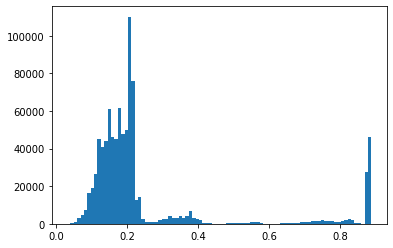

In [8]:
rows_n_nans = azdias.isnull().sum(axis=1)
plt.hist(rows_n_nans / azdias.shape[1], bins=90)

In [9]:
_, rows_droped = h.split_dataset(azdias, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
azdias.drop(index = rows_droped.index, inplace =True)
print(f'After delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the missing rows, Azdias has 891221 rows
After delete the missing rows, Azdias has 736164 rows
Delete 155057 rows in total


In [10]:
_, rows_droped = h.split_dataset(customers, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the high missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
eda_customers.data.drop(index = rows_droped.index, inplace =True)
print(f'After delete the hitg missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the high missing rate rows, Customers has 191652 rows
After delete the hitg missing rate rows, Customers has 134018 rows
Delete 57634 rows in total


##### b. Handling missing values for columns

Text(0.5, 1.0, 'Distribution of missing value per column')

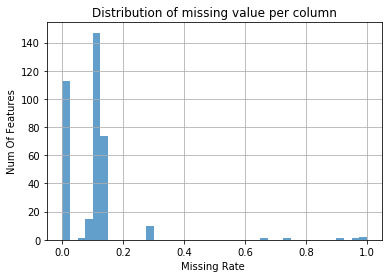

In [11]:
eda_azdias.feat_info.percent_of_nans.sort_values().hist(bins = 40, alpha = 0.7)
plt.xlabel('Missing Rate ')
plt.ylabel('Num Of Features')
plt.title('Distribution of missing value per column')

In [12]:
thr_col_missing = 0.37
feats_todrop_azdias = eda_azdias.feat_info.loc[eda_azdias.feat_info.percent_of_nans > thr_col_missing].index
feats_todrop_azdias

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [13]:
feats_todrop_customers = eda_customers.feat_info.loc[eda_customers.feat_info.percent_of_nans >thr_col_missing ].index
feats_todrop_customers

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [14]:
# Get features with high missing rates in both datasets
feats_todrop_comm = set(feats_todrop_customers).intersection(set(feats_todrop_azdias))
feats_todrop_comm = list(feats_todrop_comm)
feats_todrop.extend(feats_todrop_comm)

In [15]:
print(f'Before delete the high missing rate features/columns, {eda_azdias} has {eda_azdias.data.shape[1]} features.')
for x in feats_todrop_comm:
    if x in azdias.columns:        
        azdias.drop(columns=x, inplace=True)
print(f'After delete the high missing rate features/columns, {eda_azdias} has {eda_azdias.data.shape[1]} features.')

print()

print(f'Before delete the high missing rate features/columns, {eda_customers} has {eda_customers.data.shape[1]} features.')
for x in feats_todrop_comm:
    if x in customers.columns:        
        customers.drop(columns=x, inplace=True)

print(f'After delete the high missing rate features/columns, {eda_customers} has {eda_customers.data.shape[1]} features.')

print()
print(f'Delete {len(feats_todrop_comm)} features in total')

Before delete the high missing rate features/columns, Azdias has 350 features.
After delete the high missing rate features/columns, Azdias has 348 features.

Before delete the high missing rate features/columns, Customers has 350 features.
After delete the high missing rate features/columns, Customers has 348 features.

Delete 6 features in total


### Feature Selection

####  Step 4. Feature Selection by Data Comparison:  Customers vs. Azdias

##### a.  D19_  Features Comparison
D19_ features is about consumer mail order activities 

In [16]:
comm_feats = set(eda_customers.data.columns).intersection(set(eda_azdias.data.columns))

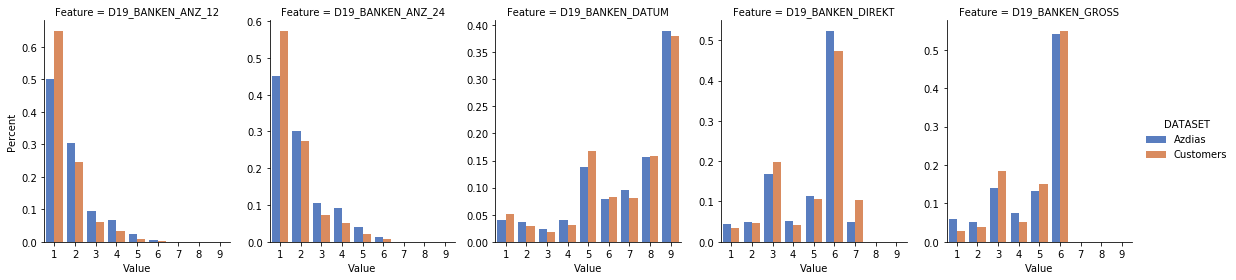

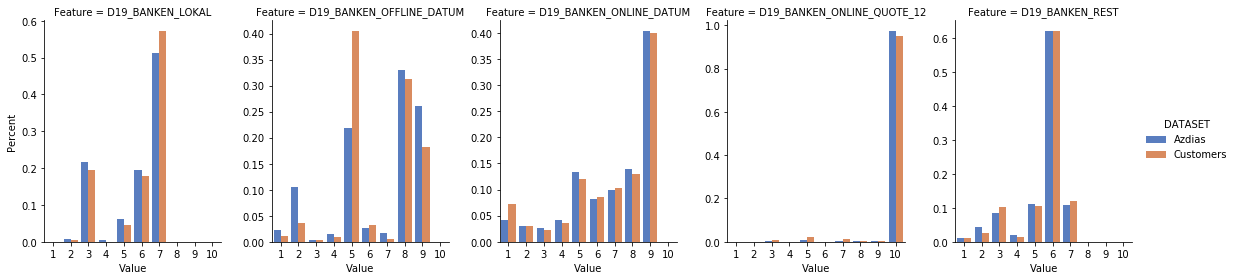

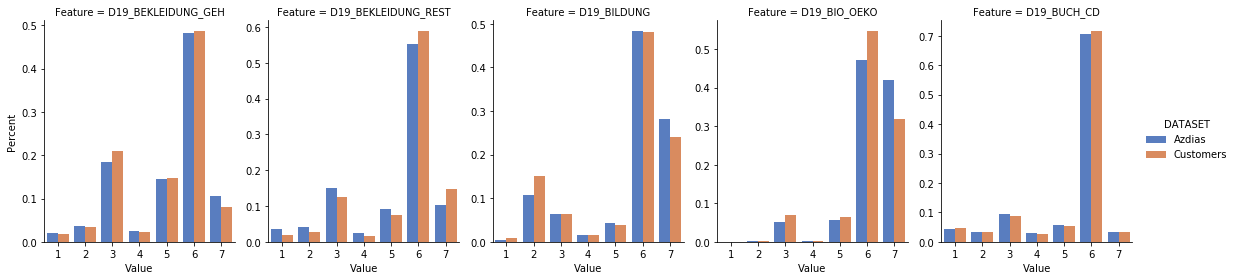

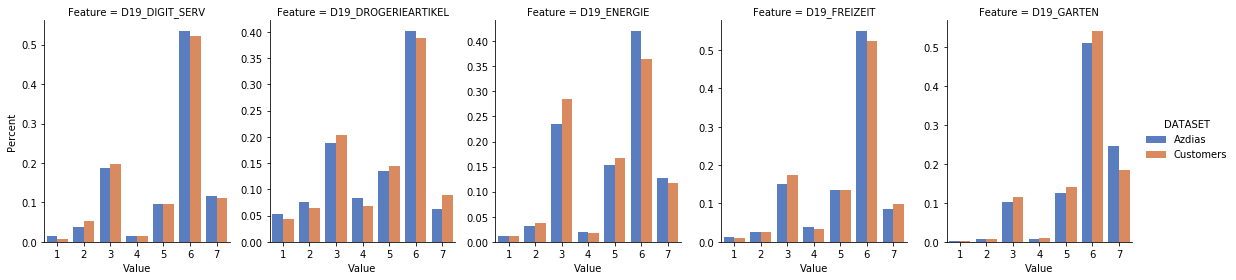

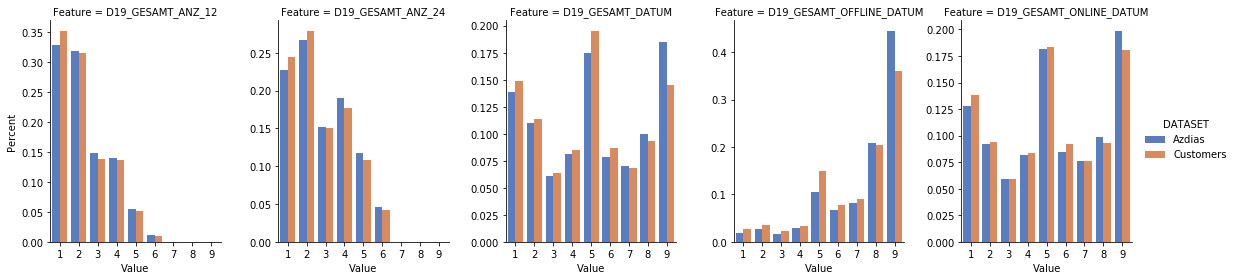

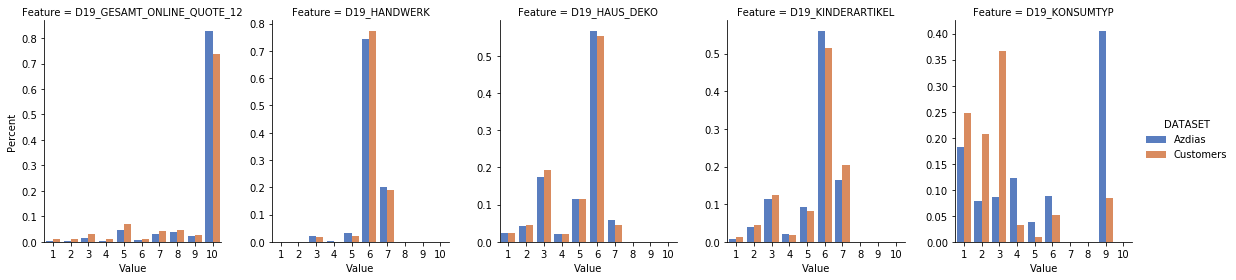

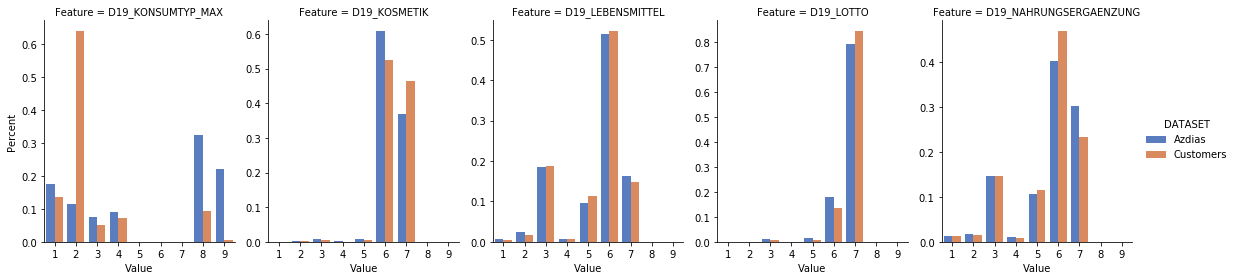

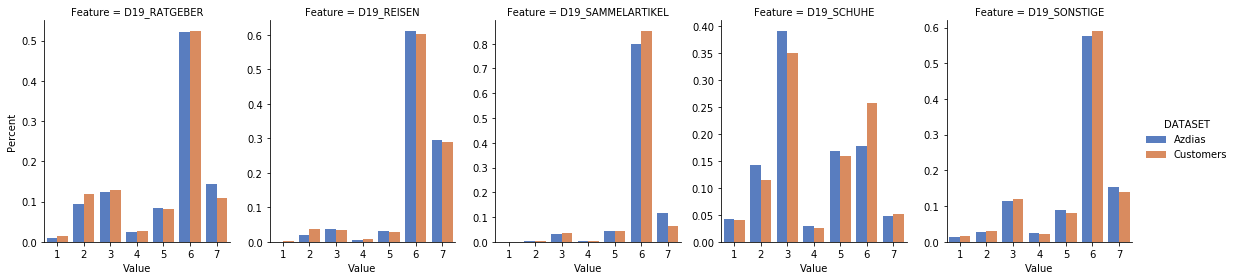

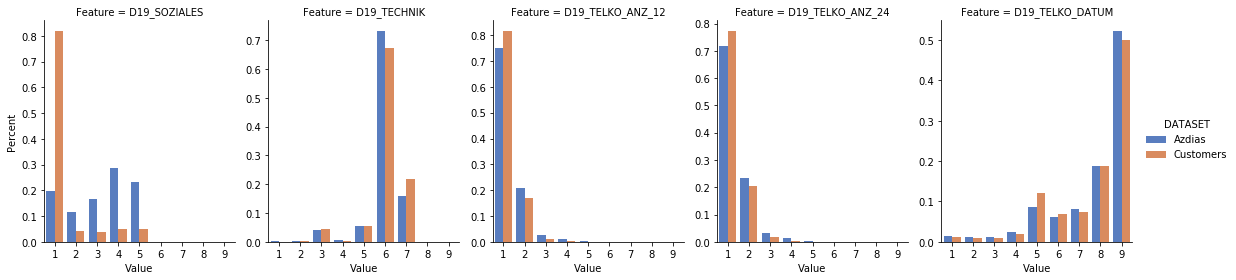

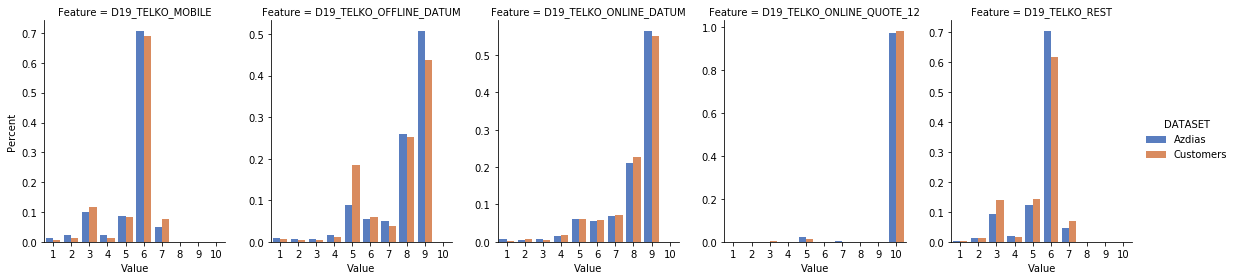

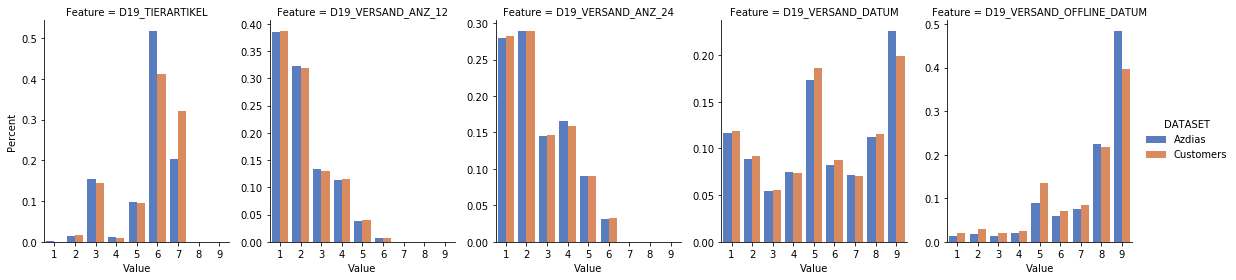

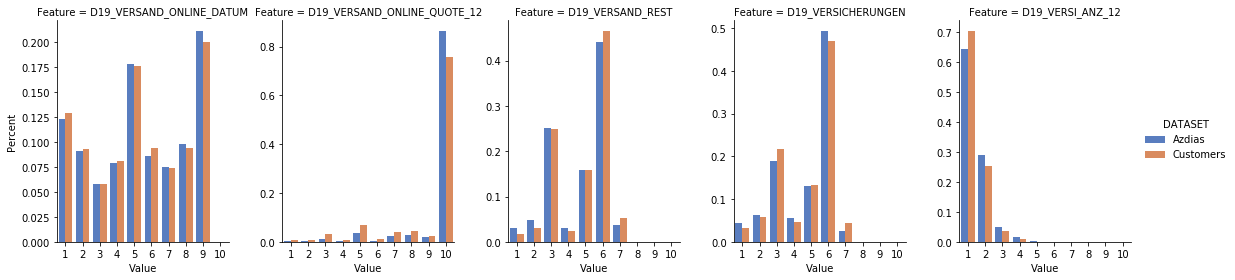

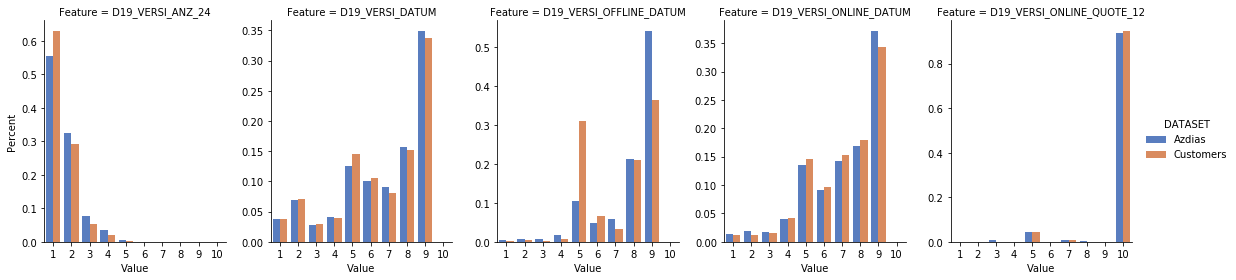

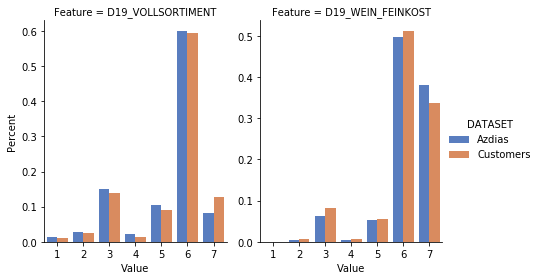

In [17]:
feats_D19 =set([x for x in comm_feats if x.startswith( 'D19_')])
feats_D19 = pd.Series(list(feats_D19)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_D19)

The feature comparison in the above figure shows:
- D19_SOZIALES: value 1 is significantly higher in customers than in azdias. Although the feature dictionary does not define D19_SOZIALES. But I guess it represents a commodity. 
- D19_KONSUMTYP:  The values of 2, 3 and 9, customers were significantly higher than azdias, They are 2: versatile, 3: Gourmet, 9 inactive, while value 9 is significantly lower than azdias. The target customers are gourmet, versatile and active.
- D19_KONSUMTYP_MAX:  value 2 is significantly higher than azdias, while value 8 is  significantly lower than azdias.
- D19_BANKEN_OFFLINE_DATUM: actuality of the last transaction for the segment banks OFFLINE,  value 5 is significantly higher than azdias,  which indicate customer slightly increased activity within the last 12 months.

In [18]:
feats_D19 = pd.Series(index = feats_D19).drop([
'D19_BANKEN_ANZ_12',
'D19_BANKEN_OFFLINE_DATUM',
'D19_KONSUMTYP',
'D19_KONSUMTYP_MAX',
'D19_SOZIALES']).index.tolist()
feats_todrop.extend(feats_D19)

eda_azdias.data.drop(columns = feats_D19, inplace =True)
eda_customers.data.drop(columns = feats_D19, inplace =True)

##### b.  KBA05_  Features Comparison

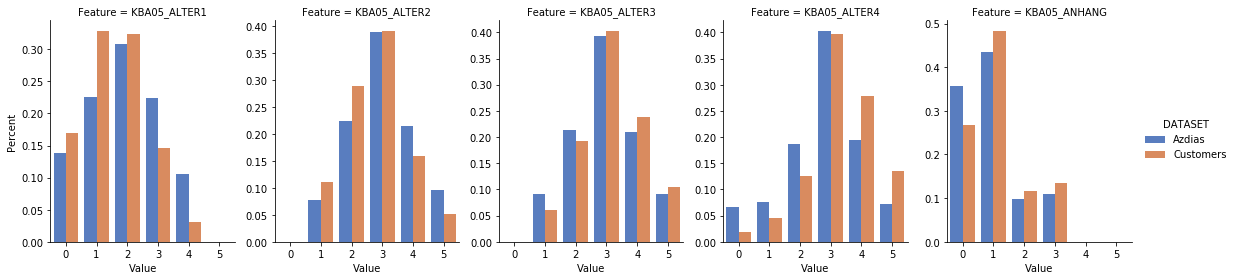

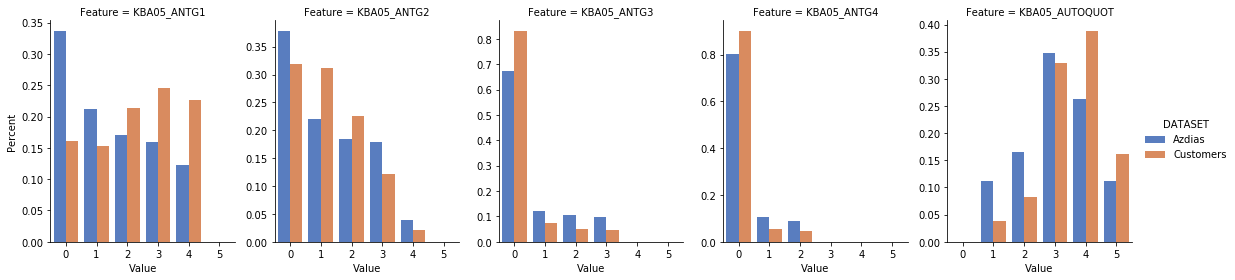

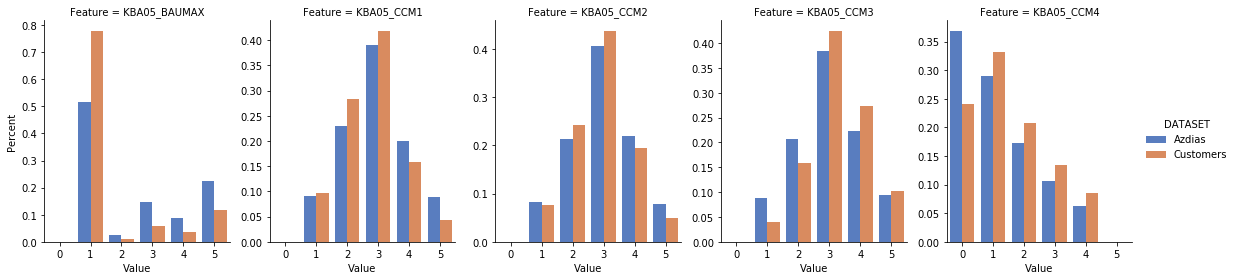

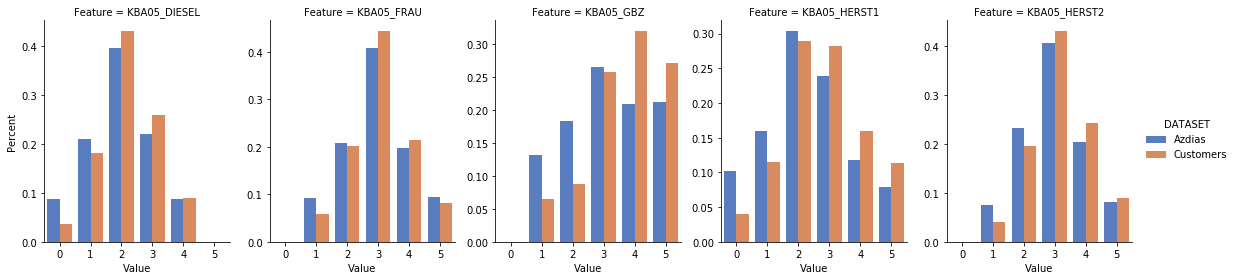

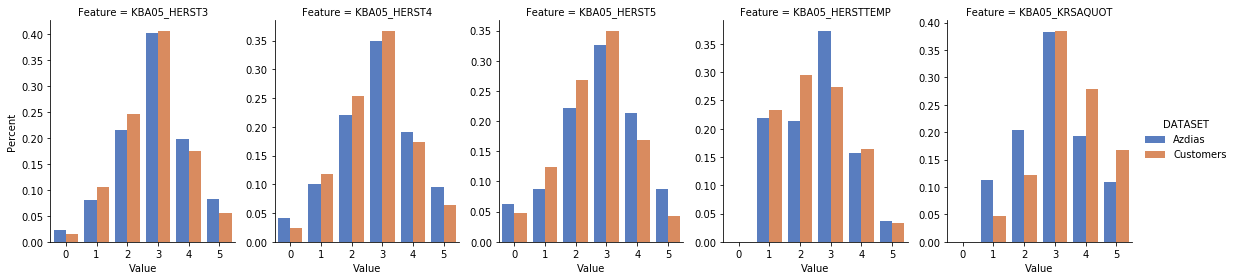

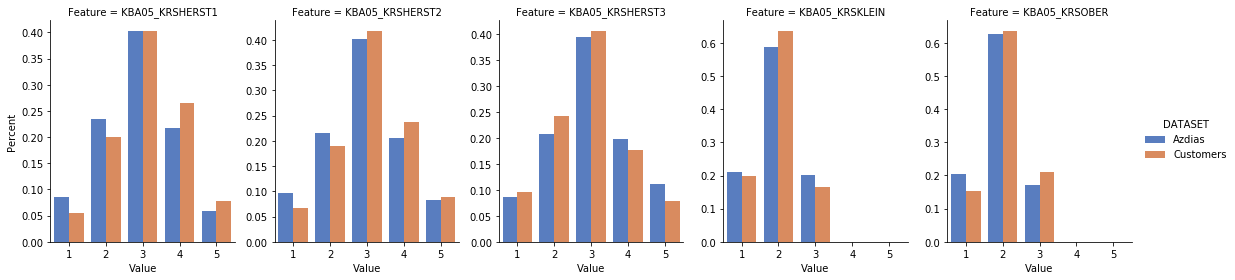

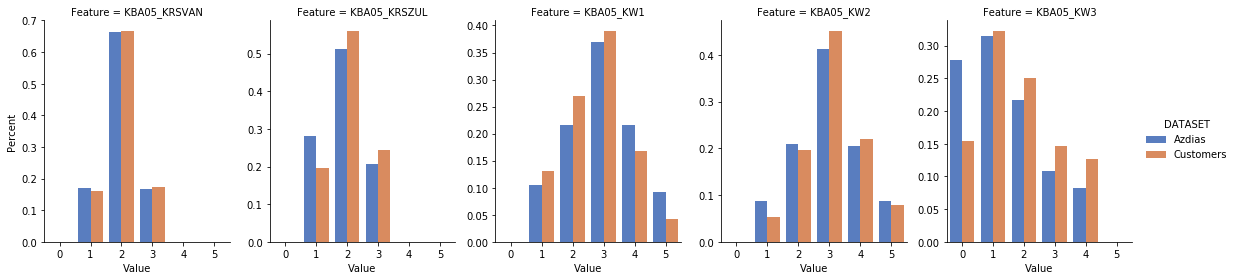

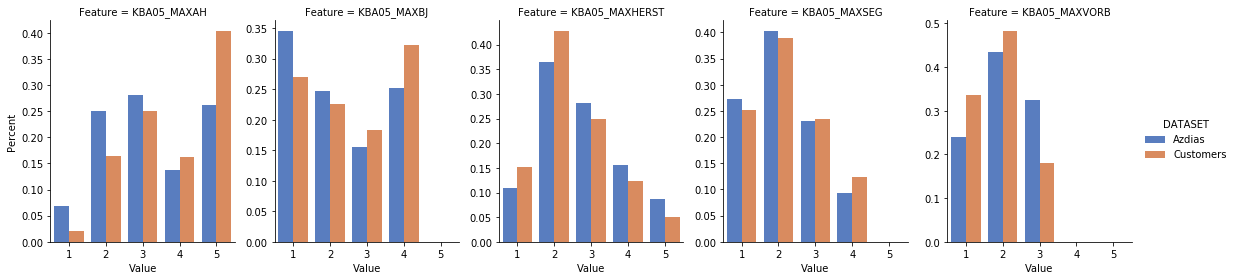

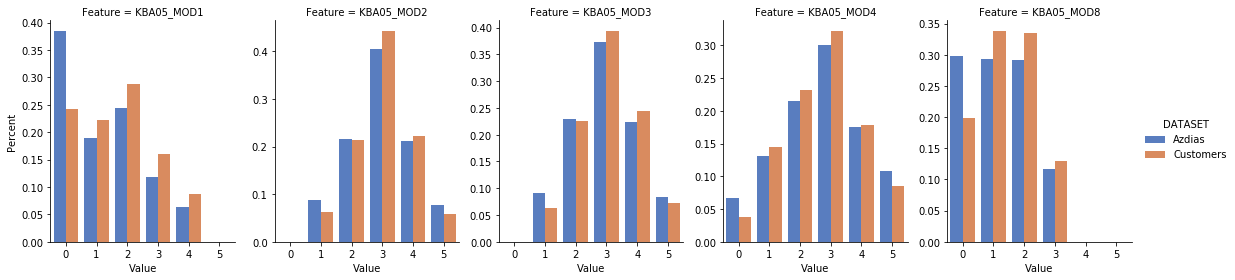

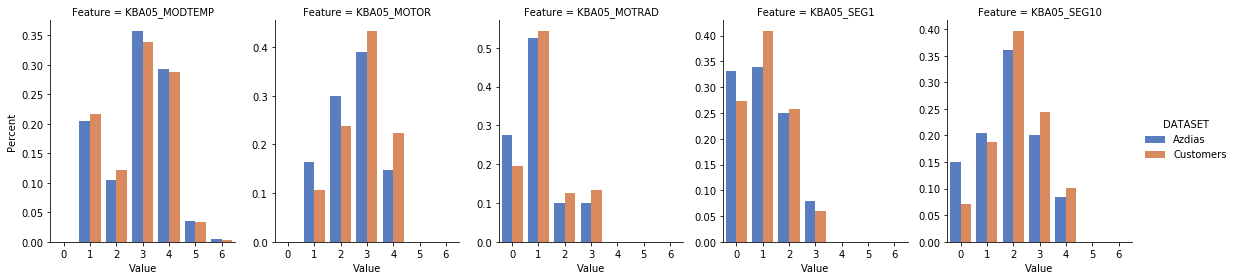

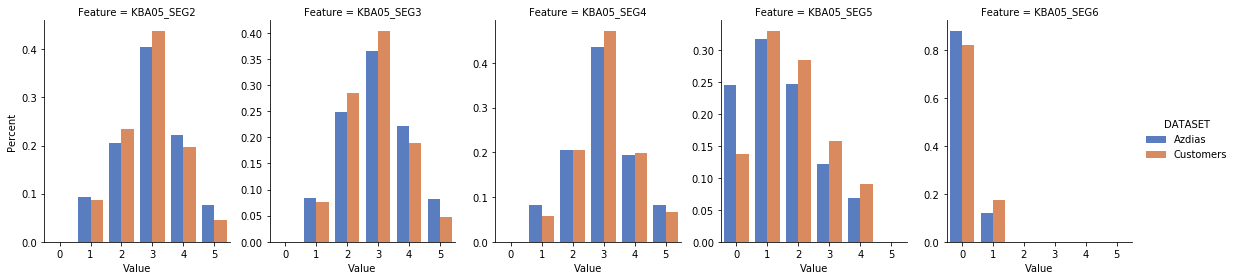

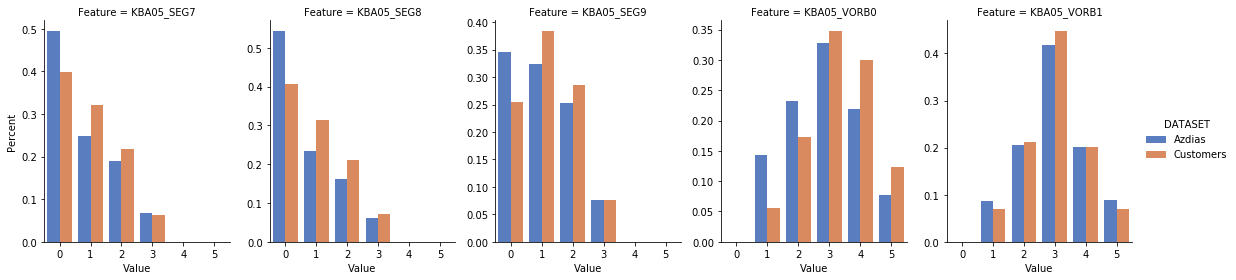

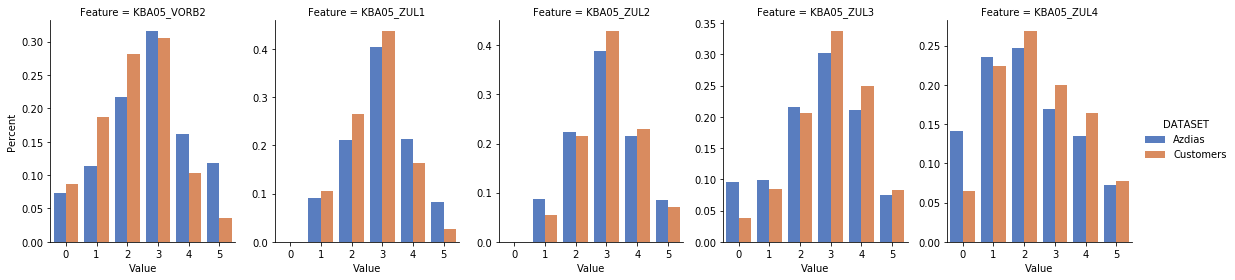

In [19]:
# feats_KBA05 =set([x for x in eda_customers.data.columns if x.startswith( 'KBA05_')])
feats_KBA05 =set([x for x in comm_feats if x.startswith( 'KBA05_')])
feats_KBA05 = pd.Series(list(feats_KBA05)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_KBA05)

In [20]:
feats_KBA05 = pd.Series(index = feats_KBA05).drop([
'KBA05_ALTER1',
'KBA05_ANTG1',
'KBA05_BAUMAX', 
'KBA05_CCM4', 
'KBA05_GBZ',
'KBA05_HERSTTEMP', 
'KBA05_KW3',
'KBA05_MOD1', 
'KBA05_SEG5',         
]).index.tolist()

feats_todrop.extend(feats_KBA05)

eda_azdias.data.drop(columns = feats_KBA05, inplace =True)
eda_customers.data.drop(columns = feats_KBA05, inplace =True)

##### b.  KBA13_  Features Comparison

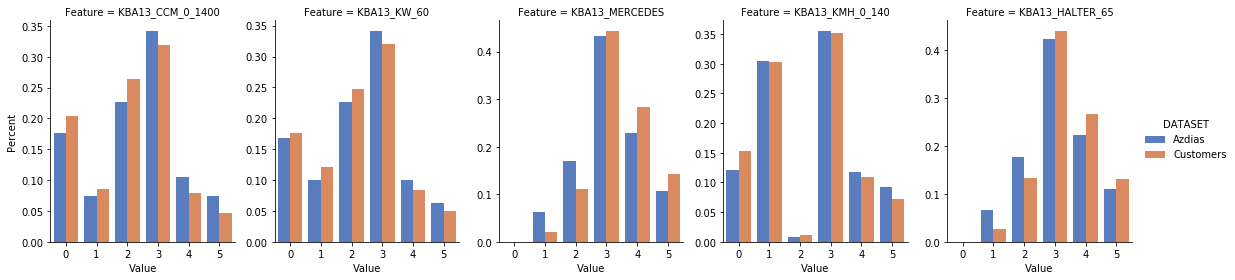

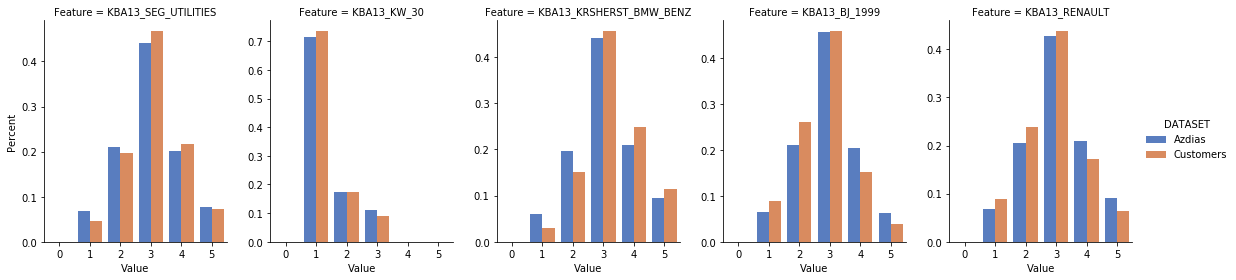

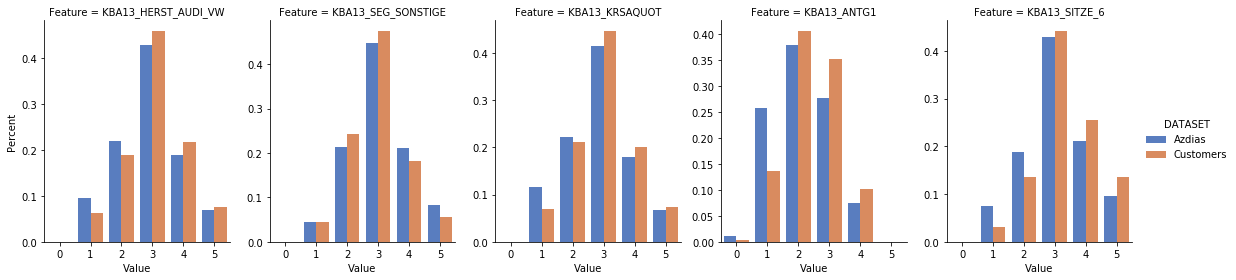

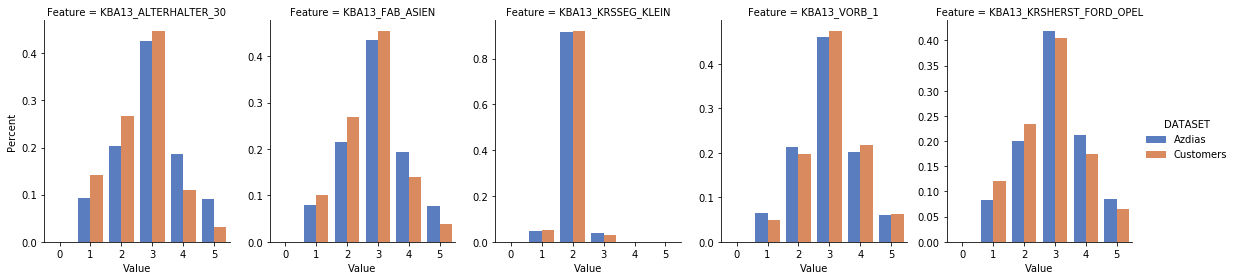

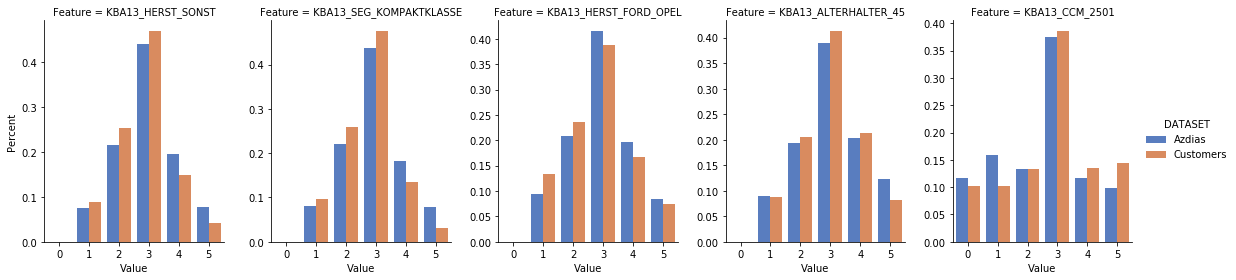

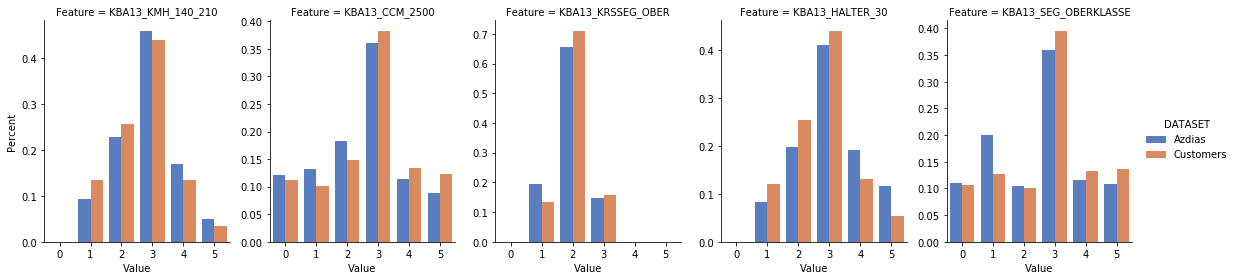

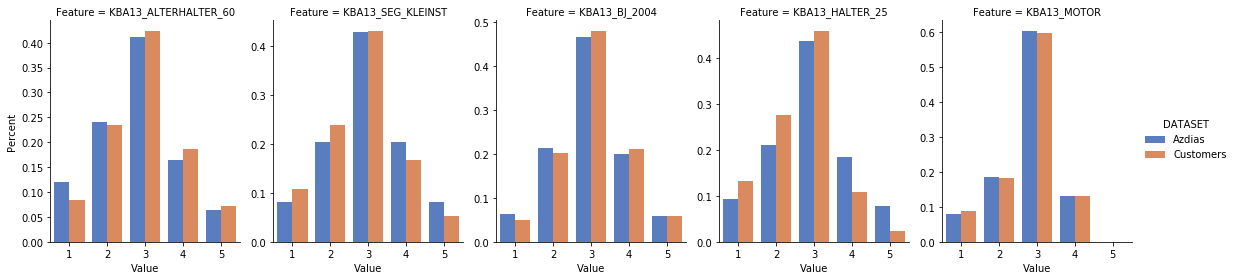

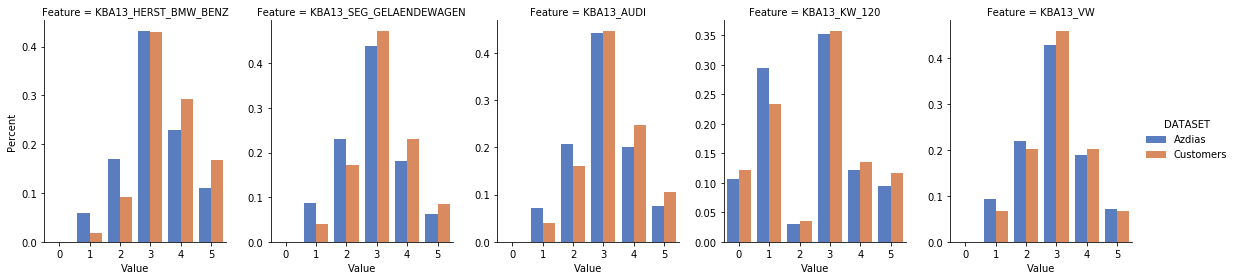

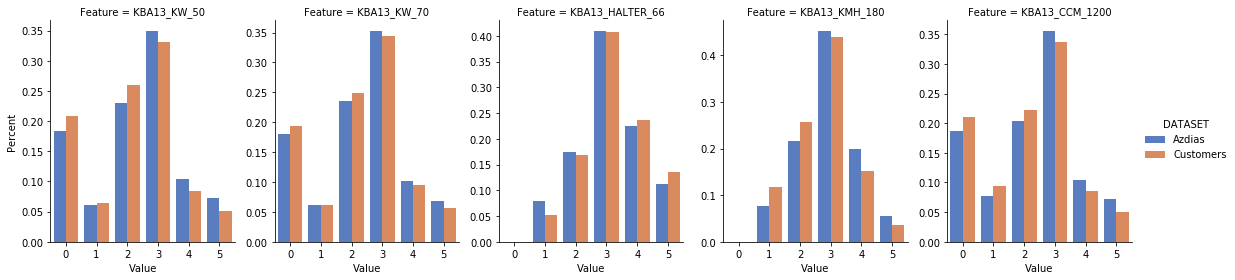

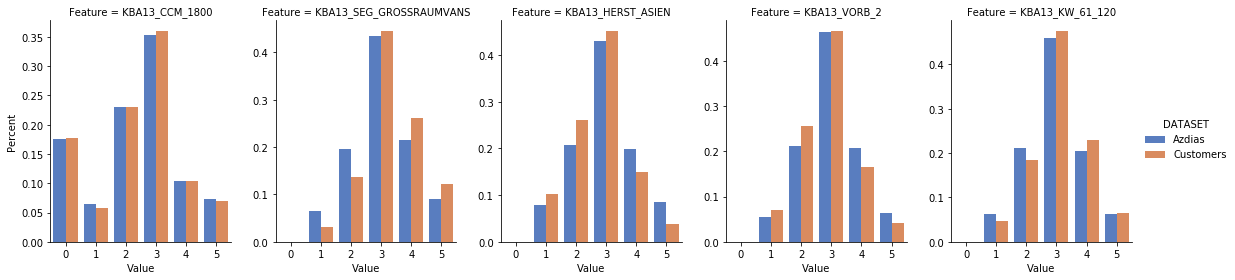

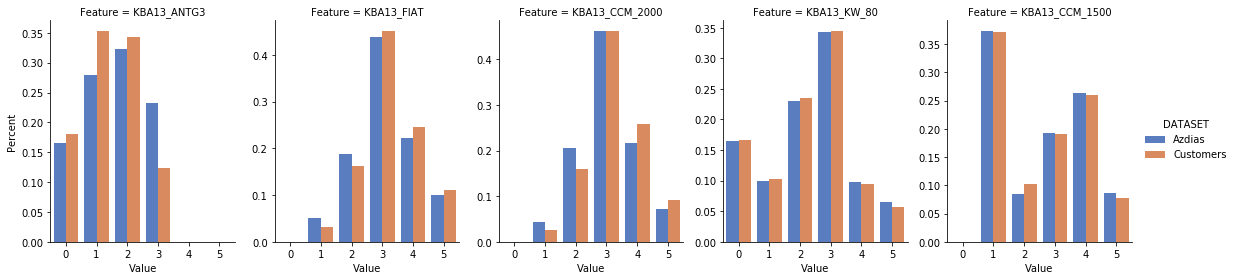

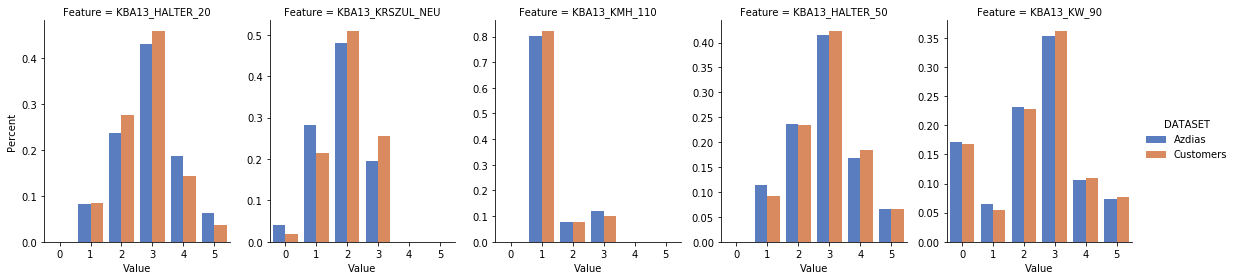

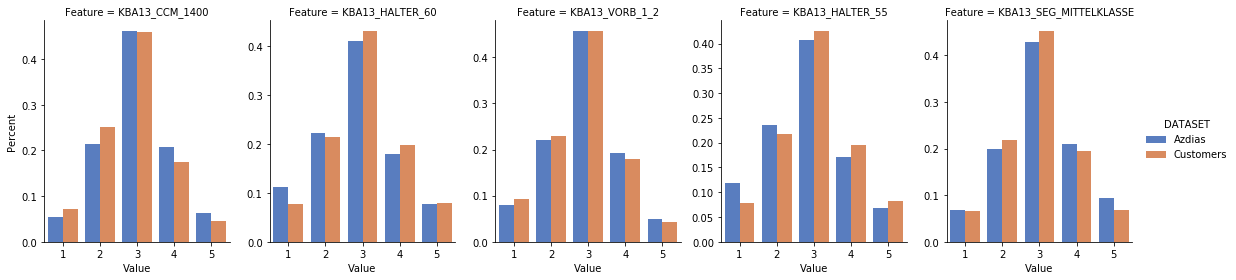

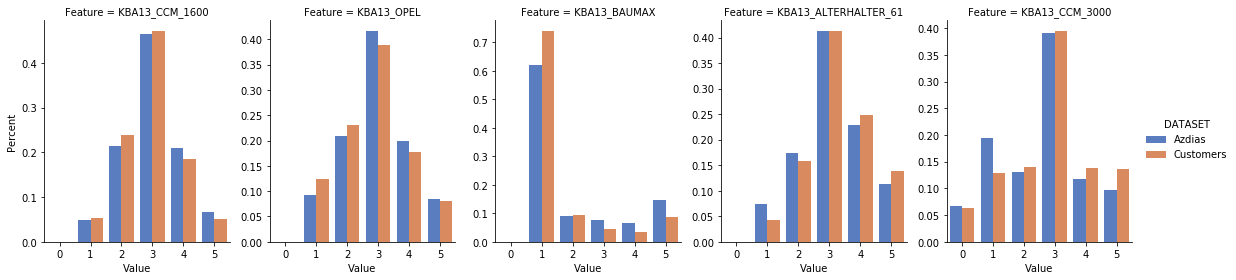

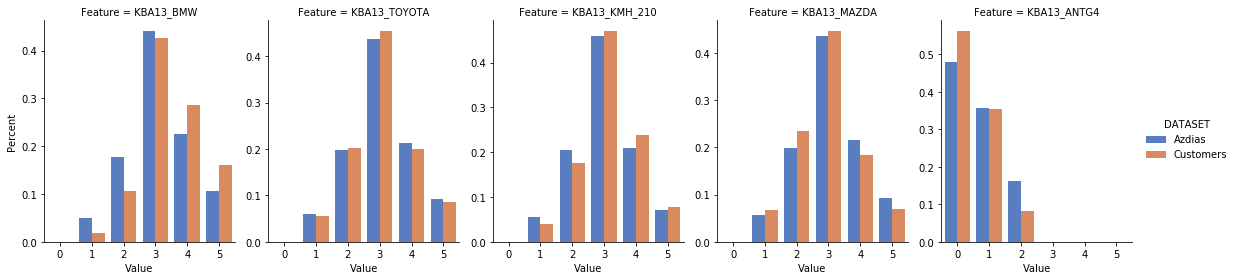

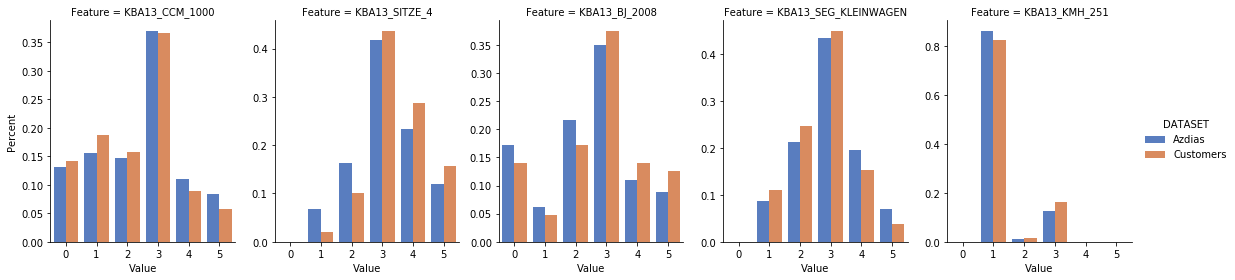

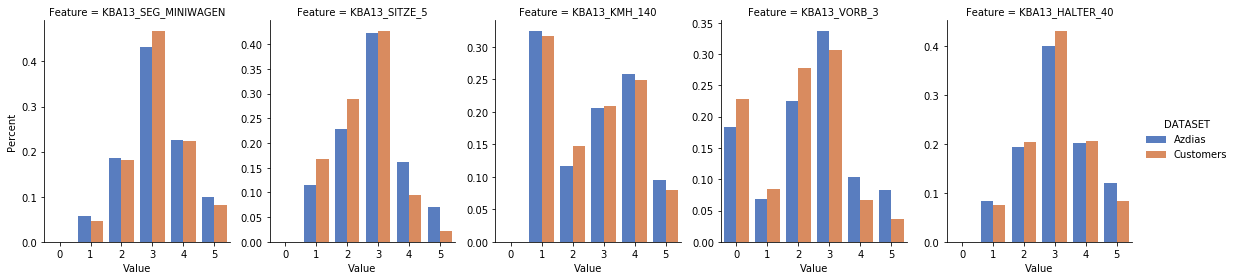

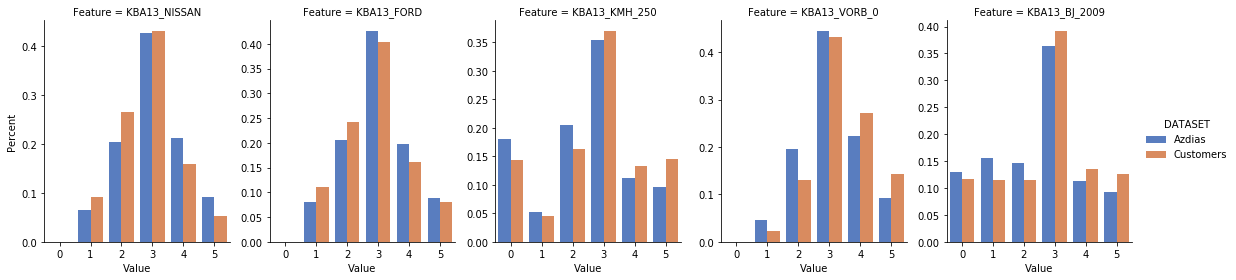

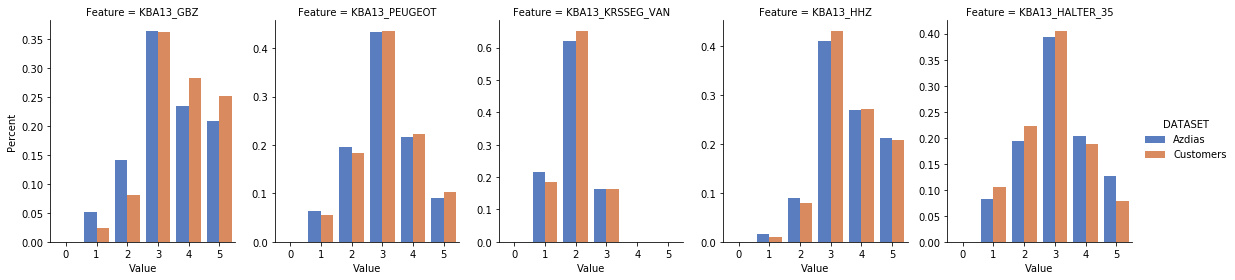

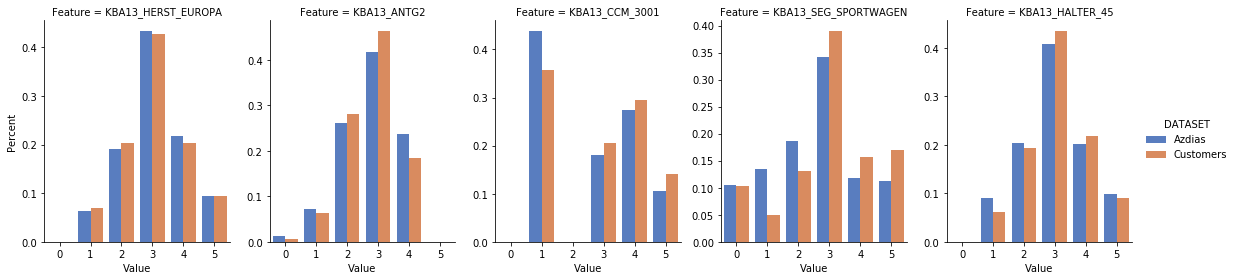

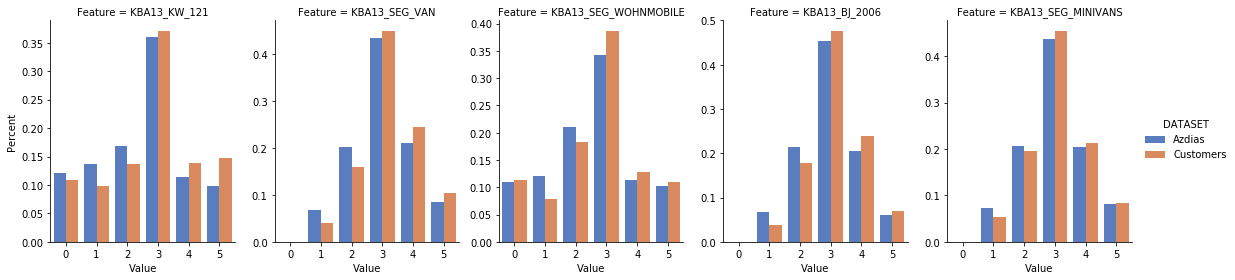

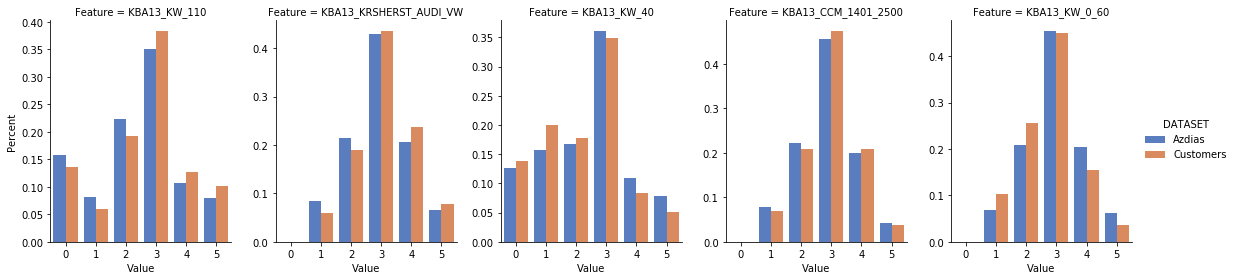

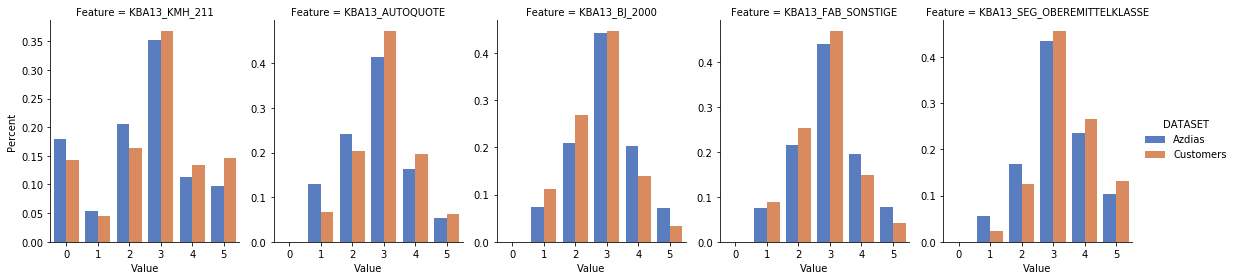

In [21]:
# feats_KBA13 =set([x for x in comm_feats if x.startswith( 'KBA13_')])
# feats_KBA13 = pd.Series(list(feats_KBA13)).sort_values().tolist()
feats_KBA13 =set([x for x in comm_feats if x.startswith( 'KBA13_')])
feats_KBA13 = pd.Series(index = list(feats_KBA13)).drop('KBA13_ANZAHL_PKW').index

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_KBA13)

In [22]:
feats_KBA13 = pd.Series(index = feats_KBA13).drop([
'KBA13_ANTG1',
'KBA13_ANTG2',
'KBA13_ANTG3',
'KBA13_ANTG4',
'KBA13_BAUMAX',
'KBA13_CCM_3000',
'KBA13_CCM_3001',
'KBA13_VORB_1',
'KBA13_VORB_1_2',
'KBA13_VORB_0',
'KBA13_VORB_2',
'KBA13_VORB_3',
'KBA13_SEG_GELAENDEWAGEN',
'KBA13_SEG_GROSSRAUMVANS',
'KBA13_SEG_KLEINST',
'KBA13_SEG_KLEINWAGEN',
'KBA13_SEG_KOMPAKTKLASSE',
'KBA13_SEG_MINIVANS',
'KBA13_SEG_MINIWAGEN',
'KBA13_SEG_MITTELKLASSE',
'KBA13_SEG_OBEREMITTELKLASSE',
'KBA13_SEG_OBERKLASSE',
'KBA13_SEG_SONSTIGE',
'KBA13_SEG_SPORTWAGEN',
'KBA13_SEG_UTILITIES',
'KBA13_SEG_VAN',
'KBA13_SEG_WOHNMOBILE',
'KBA13_AUTOQUOTE', 
'KBA13_BJ_2009',
'KBA13_BMW'    
]).index.tolist()

feats_todrop.extend(feats_KBA13)

eda_azdias.data.drop(columns = feats_KBA13, inplace =True)
eda_customers.data.drop(columns = feats_KBA13, inplace =True)

##### c.   ALTER_  Features Comparison

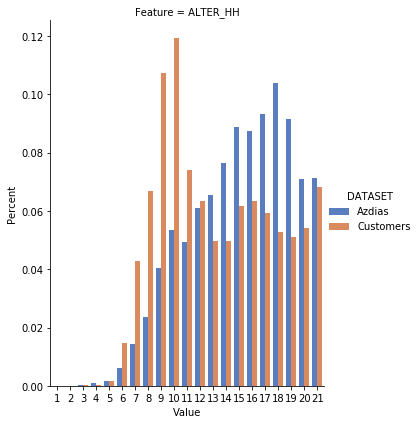

In [84]:
feats_ALTER =set([x for x in comm_feats if x.startswith( 'ALTER_')])
feats_ALTER = pd.Series(list(feats_ALTER)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_ALTER, fig_height=6)

- ALTER_HH:	main age within the household.  Value 11, 10, 9, 8, 7 are significantly higher in customers than in azdias. 
    7	01.01.1925 bis 31.12.1929
    8	01.01.1930 bis 31.12.1934
    9	01.01.1935 bis 31.12.1939
    10	01.01.1940 bis 31.12.1944
    11	01.01.1945 bis 31.12.1949

Which indicate target customer are mainly older people born in the 1920s and 1940s

##### d. CAMEO_  Features Comparison

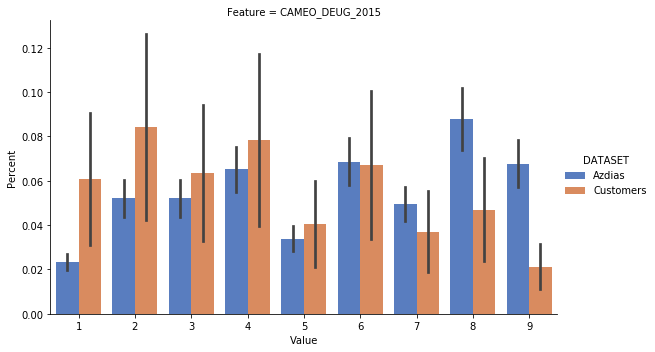

In [24]:
h.plot_feats_comparison(eda_azdias.data, eda_customers.data, ['CAMEO_DEUG_2015'], fig_height=5, fig_aspect=1.6)

- CAMEO_DEUG_2015:  New German CAMEO Typology established together with Call Credit in late 2015.
 value 1, 2 is significantly higher in customers than in azdias. while 8, 9 is significantly lower than azdias. Indicates that the target customers are middle and upper class people.

##### e.  CJT_ Features Comparison
CJT_ features is about mail order activities of consumers

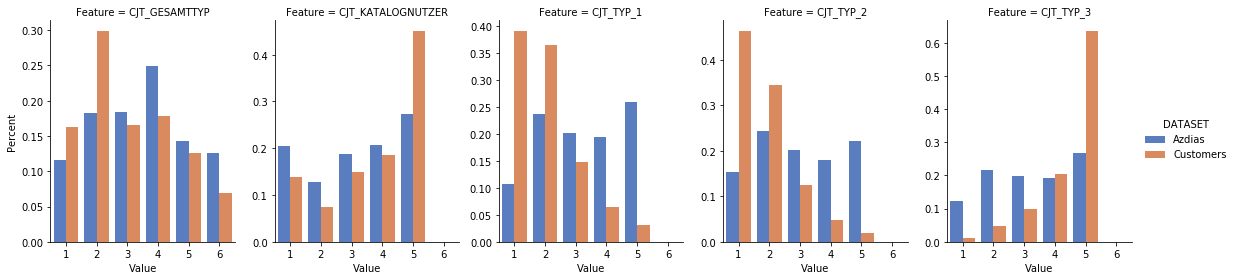

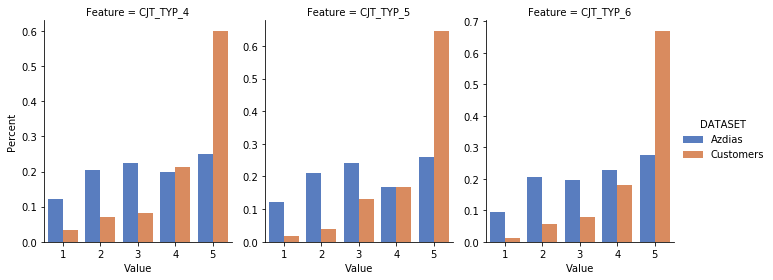

In [25]:
feats_CJT =set([x for x in comm_feats if x.startswith( 'CJT_')])
feats_CJT = pd.Series(list(feats_CJT)).sort_values().tolist()

h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats_CJT)

- CJT_GESAMTTYP :   customer journey typology.   value 2  is significantly higher in customers than in azdias. Indicates that the target customers are advertising- and consumptiontraditionalist

####  Step 5: Remove duplicate features

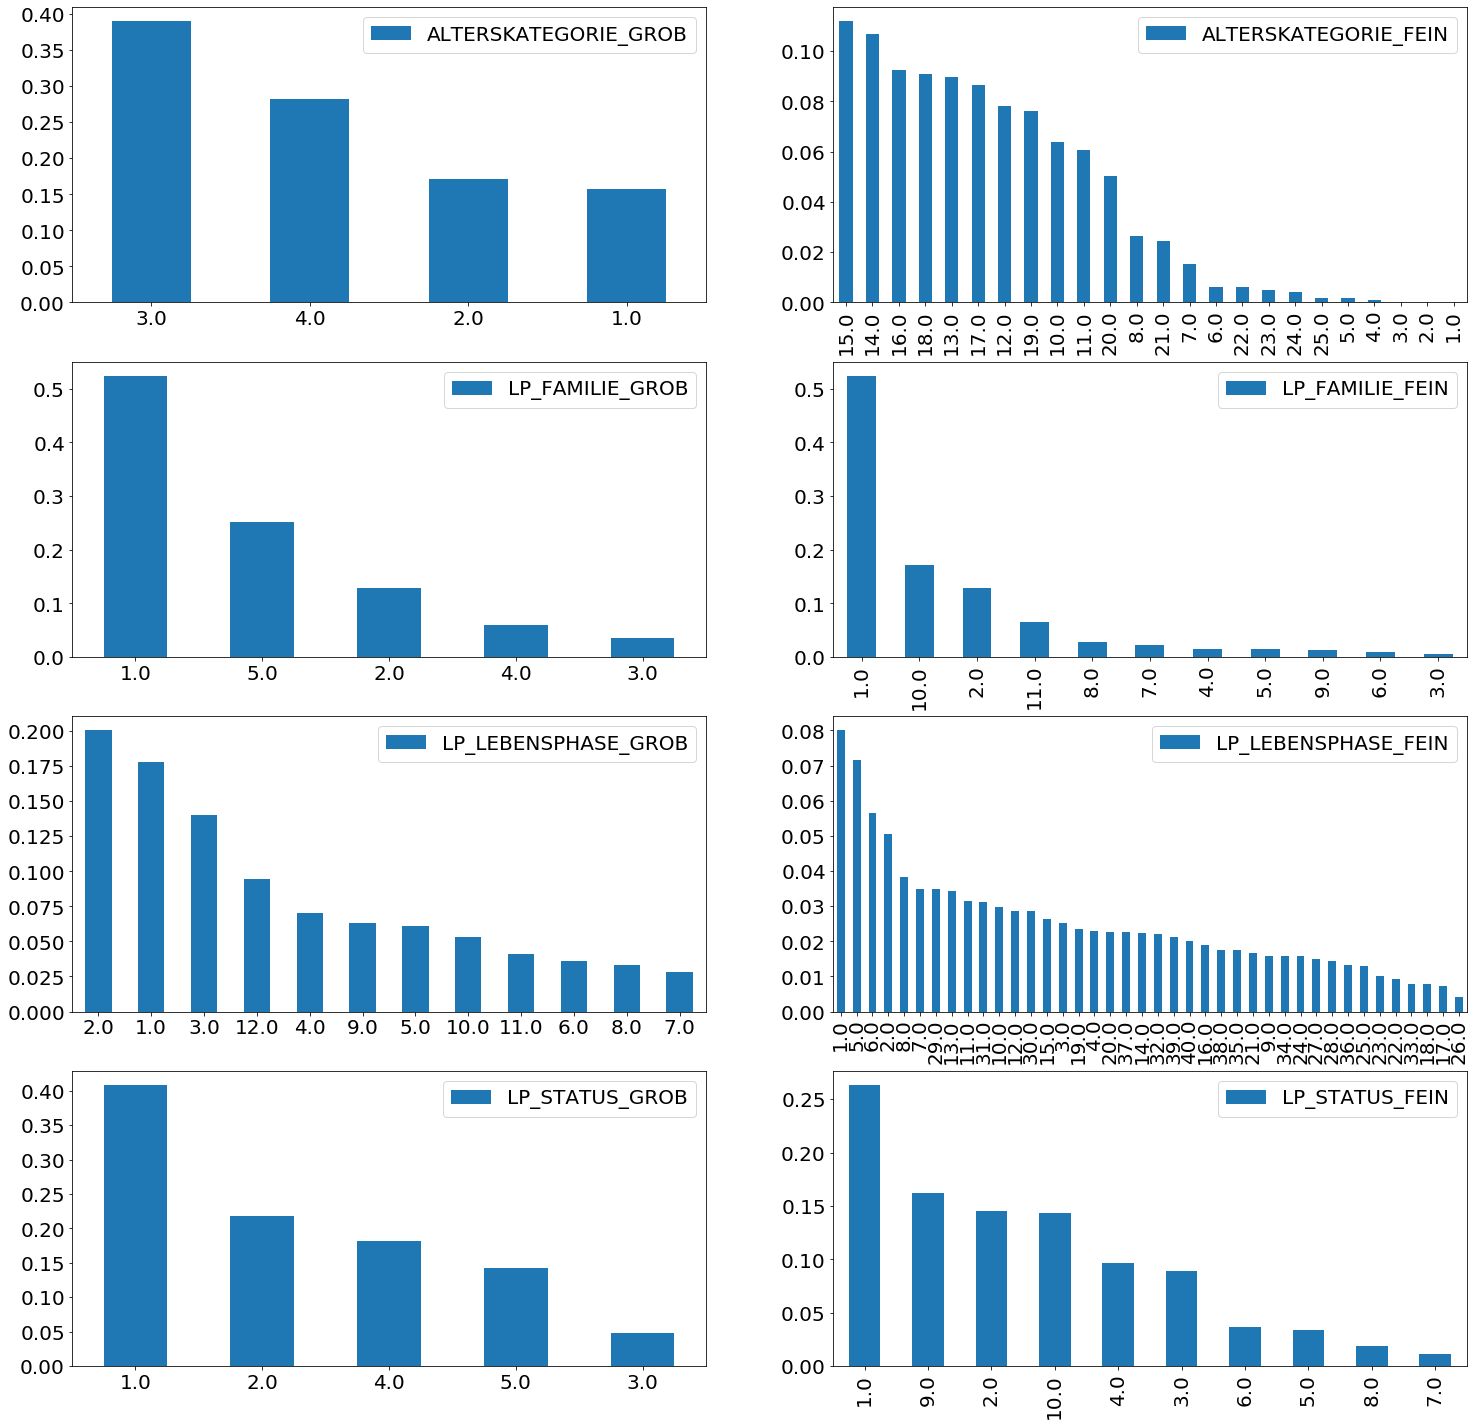

In [26]:
feats_fein =[x for x in eda_azdias.data.columns if x.endswith( '_FEIN')]
feats_grob = [x for x in eda_azdias.data.columns if x.endswith( '_GROB')]
feats_duplicate = [x for x in zip(pd.Series(feats_grob).sort_values(), pd.Series(feats_fein).sort_values())]
h.plot_2feats_comparison(eda_azdias.data, feats_duplicate)   

Both features on the same line have the same meaning. Features with a suffix of _GROB on the left represent coarse-grained information, and _FEIN represents fine-grained features. I decided to delete these duplicate features, 'ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015'. Because some of them are undefined, or  use the corresponding _GROB feature is enough.

In [27]:
feats_duplicated = ['ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB','CAMEO_DEU_2015']

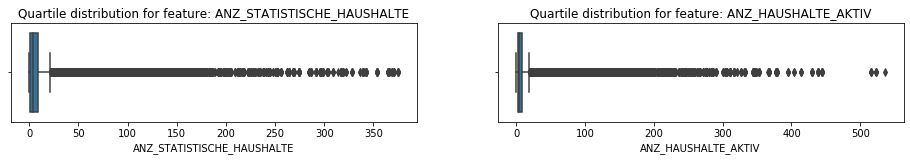

In [28]:
#  ANZ_STATISTISCHE_HAUSHALTE, ANZ_HAUSHALTE_AKTIV :  number of households in the building
#  Delete ANZ_STATISTISCHE_HAUSHALTE, because they are duplicated.

feats_HAUSHALTE = ['ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HAUSHALTE_AKTIV']
h.plot_boxplot(eda_azdias.data, feats_HAUSHALTE, n_cols =2,  figsize = (16, 4))     

In [29]:
feats_duplicated.extend(['ANZ_STATISTISCHE_HAUSHALTE'])

azdias.drop(columns=feats_duplicated, inplace=True)
customers.drop(columns=feats_duplicated, inplace=True)

feats_todrop.extend(feats_duplicated)

### Feature engineering

#### Step 6: Re-encodings features

-  'CAMEO_DEUG_2015' 
- 'CAMEO_INTL_2015' :“New German CAMEO Typology established together with Call Credit in late 2015”.
 - 'EINGEFUEGT_AM',  
 -'OST_WEST_KZ' 

In [30]:
encoding = [
                  'OST_WEST_KZ',
                  'CAMEO_DEUG_2015',
                  'CAMEO_INTL_2015',
                  'EINGEFUEGT_AM',
#                   'D19_LETZTER_KAUF_BRANCHE',    
]

h.check_features(eda_azdias, encoding)     
for x in encoding:
     print(x, eda_azdias.data[x].unique())

OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1']
CAMEO_INTL_2015 [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 41.0 34.0 55.0 33.0 25.0 nan
 23.0 31.0 52.0 45.0 35.0 44.0 32.0 '24' '41' '12' '51' '44' '35' '23'
 '25' '14' '34' '52' '55' '31' '32' '22' '15' '13' '43' '45' '33' '54']
EINGEFUEGT_AM ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00' ...
 '2006-05-12 00:00:00' '2000-03-09 00:00:00' '2005-03-19 00:00:00']


In [31]:
# feats_encoding = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE']
feats_encoding = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']

for x in feats_encoding:
    eda_azdias.re_encoding(x)
    eda_customers.re_encoding(x)        

####  Step 7. Split Mixed Features

In [32]:
mixed = eda_azdias.feat_info[ eda_azdias.feat_info['type'] == 'mixed']
mixed

,type,unknown,n_nans,percent_of_nans,count,mean,std,min,25%,50%,75%,max
CAMEO_INTL_2015,mixed,"['-1','XX']",98979,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_LEBENSPHASE_FEIN,mixed,[0],4854,0.01,886367.0,14.622637,12.616883,0.0,4.0,11.0,27.0,40.0
LP_LEBENSPHASE_GROB,mixed,[0],4854,0.01,886367.0,4.453621,3.855639,0.0,1.0,3.0,8.0,12.0
PRAEGENDE_JUGENDJAHRE,mixed,"[-1,0]",0,0.00,891221.0,8.154346,4.844532,0.0,5.0,8.0,14.0,15.0


In [33]:
mixed_feats = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
for x in mixed_feats:
    eda_azdias.process_mixed_feat(x)
    eda_customers.process_mixed_feat(x)    

In [34]:
feats_splited = ['CAMEO_INTL_2015_SPLIT_WEALTH', 'CAMEO_INTL_2015_SPLIT_LIFE_STAGE','LP_LEBENSPHASE_GROB_SPLIT_FAMILY','LP_LEBENSPHASE_GROB_SPLIT_AGE','LP_LEBENSPHASE_GROB_SPLIT_INCOME','PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE','PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT']
eda_azdias.data[feats_splited]

,CAMEO_INTL_2015_SPLIT_WEALTH,CAMEO_INTL_2015_SPLIT_LIFE_STAGE,LP_LEBENSPHASE_GROB_SPLIT_FAMILY,LP_LEBENSPHASE_GROB_SPLIT_AGE,LP_LEBENSPHASE_GROB_SPLIT_INCOME,PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT
1,5.0,1.0,2.0,NaN,NaN,5.0,0.0
2,2.0,4.0,0.0,0.0,0.0,5.0,1.0
3,1.0,2.0,NaN,NaN,NaN,3.0,0.0
4,4.0,3.0,5.0,1.0,0.0,3.0,0.0
5,5.0,4.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
891216,4.0,1.0,0.0,0.0,0.0,5.0,0.0
891217,5.0,1.0,0.0,0.0,0.0,4.0,0.0
891218,2.0,4.0,NaN,NaN,NaN,5.0,0.0
891219,5.0,1.0,5.0,0.0,0.0,5.0,0.0


In [35]:
feat_info_split = eda_azdias.build_split_feat_info(feats_splited)
eda_azdias.feat_info= pd.concat([eda_azdias.feat_info, feat_info_split], sort = False)

feat_info_split = eda_customers.build_split_feat_info(feats_splited)
eda_customers.feat_info= pd.concat([eda_customers.feat_info, feat_info_split], sort = False)
eda_azdias.feat_info.loc[feats_splited]

,type,unknown,n_nans,percent_of_nans,count,mean,std,min,25%,50%,75%,max
CAMEO_INTL_2015_SPLIT_WEALTH,split,NaN,3303,0.00,732861.0,3.279319,1.465376,1.0,2.0,4.0,5.0,5.0
CAMEO_INTL_2015_SPLIT_LIFE_STAGE,split,NaN,3303,0.00,732861.0,2.869308,1.489259,1.0,1.0,3.0,4.0,5.0
LP_LEBENSPHASE_GROB_SPLIT_FAMILY,split,NaN,42209,0.06,693955.0,1.680090,2.128974,0.0,0.0,0.0,5.0,5.0
LP_LEBENSPHASE_GROB_SPLIT_AGE,split,NaN,249862,0.34,486302.0,0.597092,0.490483,0.0,0.0,1.0,1.0,1.0
LP_LEBENSPHASE_GROB_SPLIT_INCOME,split,NaN,67138,0.09,669026.0,0.384215,0.486410,0.0,0.0,0.0,1.0,1.0
PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,split,NaN,20869,0.03,715295.0,3.311204,1.460728,0.0,2.0,3.0,5.0,5.0
PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT,split,NaN,20869,0.03,715295.0,0.230297,0.421023,0.0,0.0,0.0,0.0,1.0


In [36]:
eda_azdias.update_stats()
eda_customers.update_stats()

#### Step 8.  Cleaning outliers

#####  a. Analysis outliers for  numeric features

In [37]:
eda_azdias.feat_info.loc[eda_azdias.feat_info.type == 'numeric']

,type,n_nans,percent_of_nans,count,mean,std,min,25%,50%,75%,max
ANZ_HAUSHALTE_AKTIV,numeric,0.0,0.00,736164.0,8.175594,15.110401,0.0,2.0,4.0,9.0,536.0
ANZ_HH_TITEL,numeric,3303.0,0.00,732861.0,0.039189,0.312081,0.0,0.0,0.0,0.0,20.0
ANZ_KINDER,numeric,0.0,0.00,736164.0,0.146317,0.488937,0.0,0.0,0.0,0.0,11.0
ANZ_PERSONEN,numeric,0.0,0.00,736164.0,1.739573,1.164320,0.0,1.0,1.0,2.0,38.0
ANZ_STATISTISCHE_HAUSHALTE,numeric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANZ_TITEL,numeric,0.0,0.00,736164.0,0.004139,0.068223,0.0,0.0,0.0,0.0,4.0
EINGEFUEGT_AM,numeric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EINGEZOGENAM_HH_JAHR,numeric,0.0,0.00,736164.0,2003.401006,7.052220,1900.0,1997.0,2003.0,2009.0,2018.0
GEBURTSJAHR,numeric,286718.0,0.39,449446.0,1966.928405,17.858387,1900.0,1954.0,1967.0,1981.0,2017.0
KBA13_ANZAHL_PKW,numeric,0.0,0.00,736164.0,618.051074,337.472307,0.0,384.0,548.0,775.0,2300.0


In [38]:
eda_azdias.feat_info[eda_azdias.feat_info['count'] > 100]

,type,n_nans,percent_of_nans,count,mean,std,min,25%,50%,75%,max
AGER_TYP,categorical,546750.0,0.74,189414.0,1.720570,0.676613,1.0,1.0,2.0,2.0,3.0
ALTERSKATEGORIE_GROB,ordinal,2567.0,0.00,733597.0,2.796537,1.019073,1.0,2.0,3.0,4.0,4.0
ALTER_HH,ordinal,210565.0,0.29,525599.0,15.272270,3.806668,1.0,12.0,16.0,18.0,21.0
ANREDE_KZ,categorical,0.0,0.00,736164.0,1.521099,0.499555,1.0,1.0,2.0,2.0,2.0
ANZ_HAUSHALTE_AKTIV,numeric,0.0,0.00,736164.0,8.175594,15.110401,0.0,2.0,4.0,9.0,536.0
...,...,...,...,...,...,...,...,...,...,...,...
VK_ZG11,ordinal,90687.0,0.12,645477.0,5.354304,2.498507,1.0,3.0,5.0,7.0,11.0
WOHNDAUER_2008,ordinal,0.0,0.00,736164.0,7.966048,1.888066,1.0,8.0,9.0,9.0,9.0
WOHNLAGE,ordinal,22.0,0.00,736142.0,4.054424,1.896703,1.0,3.0,3.0,5.0,8.0
W_KEIT_KIND_HH,ordinal,54011.0,0.07,682153.0,4.184995,1.766670,1.0,3.0,4.0,6.0,6.0


In [39]:
# Delete  'KBA13_ANZAHL_PKW'  and ' ANZ_HAUSHALTE_AKTIV'  , Because they have 221 and 1245 unique values, respectively, it is not good for subsequent cluster comparisons
feats_todrop.extend(['KBA13_ANZAHL_PKW','ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN'])

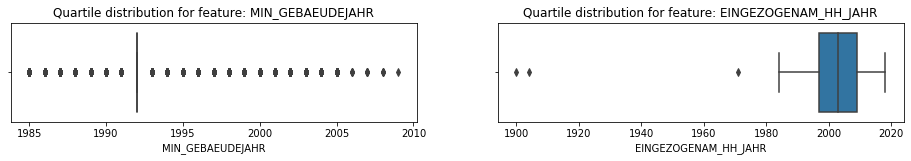

In [40]:
numeric_outlier_feats = ['MIN_GEBAEUDEJAHR' , 'EINGEZOGENAM_HH_JAHR']
h.plot_boxplot(eda_azdias.data, numeric_outlier_feats, n_cols=2,  figsize = (16, 4))

In [41]:
eda_azdias.feat_info['25%']

AGER_TYP                 1.0
AKT_DAT_KL               NaN
ALTERSKATEGORIE_FEIN     NaN
ALTERSKATEGORIE_GROB     2.0
ALTER_HH                12.0
                        ... 
VK_ZG11                  3.0
WOHNDAUER_2008           8.0
WOHNLAGE                 3.0
W_KEIT_KIND_HH           3.0
ZABEOTYP                 3.0
Name: 25%, Length: 385, dtype: float64

Cleaning outliers for MIN_GEBAEUDEJAHR  ...
Cleaning outliers for EINGEZOGENAM_HH_JAHR  ...


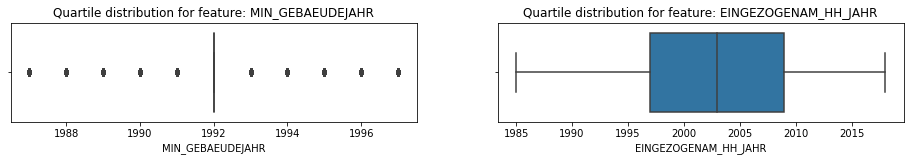

In [42]:
eda_azdias.clean_outlier(numeric_outlier_feats)
h.plot_boxplot(eda_azdias.data, numeric_outlier_feats, n_cols=2,  figsize = (16, 4))

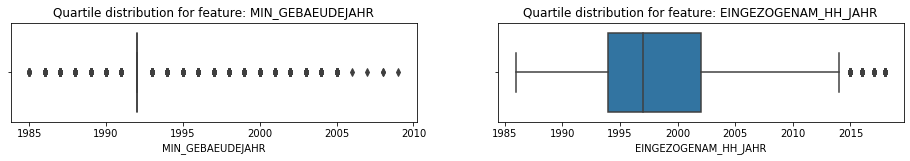

In [43]:
h.plot_boxplot(eda_customers.data, numeric_outlier_feats, n_cols=2,  figsize = (16, 4))     

#####  a. Analysis outliers for  categorical features

In [44]:
eda_azdias.feat_info.loc[eda_azdias.feat_info.type == 'categorical']

,type,n_nans,percent_of_nans,count,mean,std,min,25%,50%,75%,max
AGER_TYP,categorical,546750.0,0.74,189414.0,1.720570,0.676613,1.0,1.0,2.0,2.0,3.0
ANREDE_KZ,categorical,0.0,0.00,736164.0,1.521099,0.499555,1.0,1.0,2.0,2.0,2.0
CAMEO_DEUG_2015,categorical,3303.0,0.00,732861.0,5.564770,2.488495,1.0,3.0,6.0,8.0,9.0
CAMEO_DEU_2015,categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CJT_GESAMTTYP,categorical,3431.0,0.00,732733.0,3.497694,1.532541,1.0,2.0,4.0,5.0,6.0
CJT_TYP_1,categorical,3431.0,0.00,732733.0,3.264996,1.352186,1.0,2.0,3.0,5.0,5.0
CJT_TYP_2,categorical,3431.0,0.00,732733.0,3.071879,1.384561,1.0,2.0,3.0,4.0,5.0
CJT_TYP_3,categorical,3431.0,0.00,732733.0,3.266330,1.381021,1.0,2.0,3.0,5.0,5.0
CJT_TYP_4,categorical,3431.0,0.00,732733.0,3.251849,1.351780,1.0,2.0,3.0,5.0,5.0
CJT_TYP_5,categorical,3431.0,0.00,732733.0,3.230699,1.358475,1.0,2.0,3.0,5.0,5.0


In [45]:
h.check_features(eda_azdias, 'categorical')      

AGER_TYP [nan  2.  3.  1.]
ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  7.  5.  3. nan]
CAMEO_DEU_2015 was eliminated already
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
CJT_TYP_1 [ 5.  4.  2.  3.  1. nan]
CJT_TYP_2 [ 5.  4.  2.  3.  1. nan]
CJT_TYP_3 [ 2.  1.  4.  3.  5. nan]
CJT_TYP_4 [ 3.  4.  5.  1.  2. nan]
CJT_TYP_5 [ 1.  2.  5.  3.  4. nan]
CJT_TYP_6 [ 1.  2.  3.  4.  5. nan]
D19_KONSUMTYP [nan  9.  1.  4.  3.  6.  5.  2.]
D19_KONSUMTYP_MAX [9 8 1 2 4 3]
DSL_FLAG [1. 0.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GEMEINDETYP [22. 40. 21. 12. 30. 50. 11. nan]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
HH_DELTA_FLAG [ 0. nan  1.]
KK_KUNDENTYP was eliminated already
KONSUMZELLE [ 1.  0. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB was eliminated already
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  8.  5.  6.  7. nan]
LP_STATUS_GROB was eliminated already
NATIONALITAE

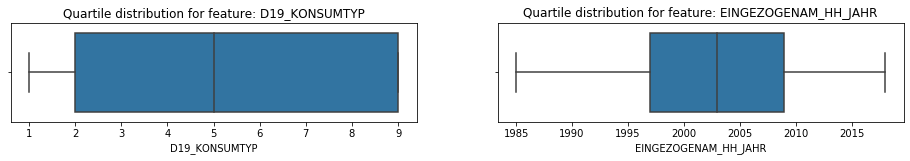

In [46]:
cat_outlier_feats  = ['D19_KONSUMTYP', 'EINGEZOGENAM_HH_JAHR']
h.plot_boxplot(eda_azdias.data, cat_outlier_feats, n_cols=2 ,  figsize = (16, 4))     

In [47]:
# eda_azdias.clean_outlier(numeric_outlier_feats)
# h.plot_boxplot(eda_azdias.data, cat_outlier_feats, n_cols=2 ,  figsize = (16, 4))     

##  Step  8:  Impute missing value

In [48]:
# Save the droped  features into a file.
# for x in (feats_todrop_comm, feats_duplicated, feats_wo_def, feats_D19, feats_KBA05, feats_KBA13):
#     feats_todrop.extend(x)
# for c in feats_todrop:
#     if c in eda_azdias.data.columns:
#         eda_azdias.data.drop(columns = c, inplace = True)     
        
#     if c in eda_customers.data.columns:
#         eda_customers.data.drop(columns = c, inplace = True)             
    
pd.Series(feats_todrop).sort_values().to_csv('feats_dropped.csv', index=False)

In [49]:
imputer = Imputer(strategy='median')
eda_azdias.data_imputed = pd.DataFrame(imputer.fit_transform(eda_azdias.data))
eda_customers.data_imputed = pd.DataFrame(imputer.fit_transform(eda_customers.data))

####  Step  9:   Feature  Scaling

In [50]:
eda_azdias.data_scaled = StandardScaler().fit_transform(eda_azdias.data_imputed)    
eda_customers.data_scaled = pd.DataFrame(StandardScaler().fit_transform(eda_customers.data_imputed) , columns=eda_customers.data.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal component analysis (PCA)

total explained_variance:  0.948481403764339
n_components:  100


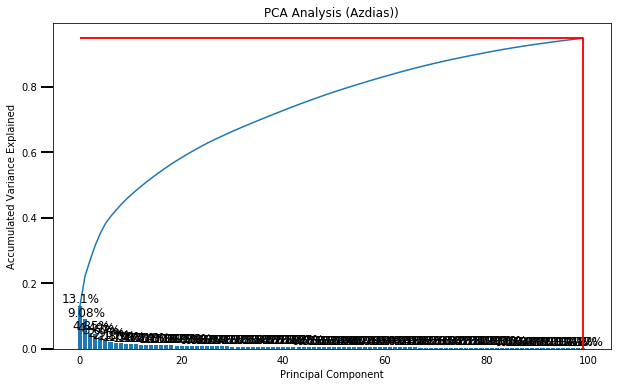

In [51]:
h.do_pca(eda_azdias, 100)

print(f'total explained_variance:  {eda_azdias.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_azdias.pca.n_components_)

h.scree_plot(eda_azdias)

total explained_variance:  0.9443851983287033
n_components:  100


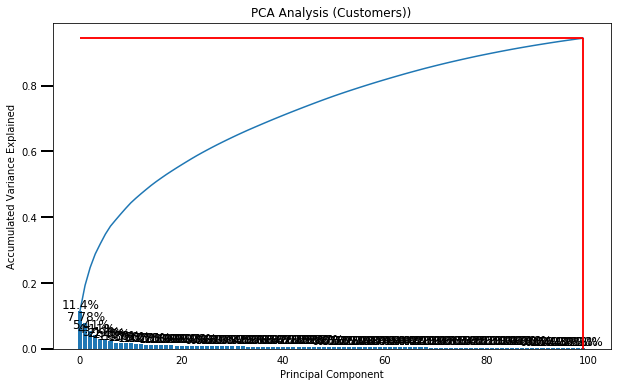

In [54]:
h.do_pca(eda_customers, 100)

print(f'total explained_variance:  {eda_customers.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_customers.pca.n_components_)

h.scree_plot(eda_customers)

### Clustering with KMean

In [55]:
h.do_pca(eda_azdias, 100)
h.do_pca(eda_customers, 100)

Text(0.5, 1.0, 'SSE vs. K')

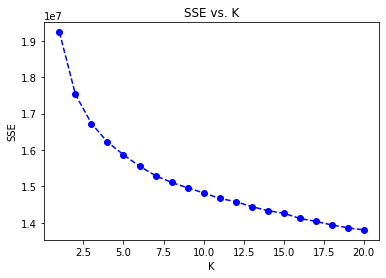

In [56]:
scores = []
centers = list(range(1,21))

for center in centers:
    _, score = h.get_kmeans_score(eda_customers.X_pca, center)
    scores.append(score)
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

####  Clustering Comparison  Azdias vs Customers 

In [57]:
model_c, score = h.get_kmeans_score(eda_customers.X_pca, 10)
print(score)
model_a, score = h.get_kmeans_score(eda_azdias.X_pca, 10)
print(score)

14820182.691
80403479.61


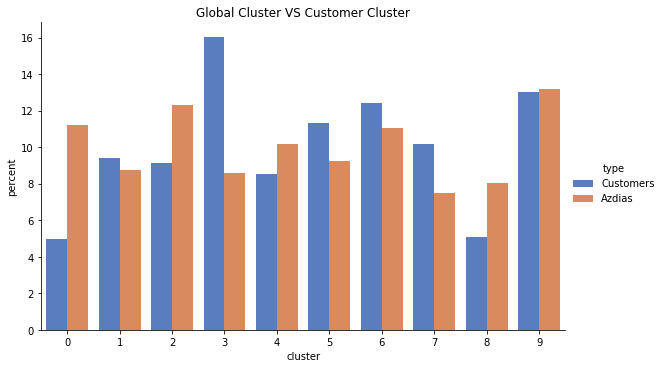

In [58]:
preds_c = model_c.predict(eda_customers.X_pca)
preds_a = model_a.predict(eda_azdias.X_pca)

counts_c, counts_a = h.plot_cluster_comparison(preds_c, preds_a)

In [59]:
comp_diff_s = (counts_c.percent - counts_a.percent).sort_values(ascending=False)
pd.DataFrame(
    {
        'cluster': comp_diff_s.index,
        'diff_pct': comp_diff_s.values
    }
)

,cluster,diff_pct
0,3,7.470362
1,7,2.695246
2,5,2.051469
3,6,1.356237
4,1,0.638408
5,9,-0.168279
6,4,-1.639662
7,8,-2.996246
8,2,-3.175297
9,0,-6.232236


In [85]:
h.list_component(eda_customers,  3)

[['ANREDE_KZ', 0.29564963204973865],
 ['SEMIO_KAEM', 0.2740094385032887],
 ['SEMIO_KRIT', 0.2512335394108711],
 ['SEMIO_DOM', 0.24804353507330323],
 ['SEMIO_ERL', 0.2111127176714465],
 '^^^HEAD',
 'TAILvvv',
 ['SEMIO_SOZ', -0.16999949172229636],
 ['SEMIO_REL', -0.21504606885390817],
 ['SEMIO_FAM', -0.24835686142731953],
 ['SEMIO_VERT', -0.25329456426391334],
 ['SEMIO_KULT', -0.2666708611957348]]

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Step 1: Load the data

In [69]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_pickle ('..//data//mailout_train.p')    
mailout_train.shape

(42962, 367)

### Step 2: Preparing and splitting the data

In [70]:
positive_cnts = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]
total_cnts = mailout_train.shape[0]
 
print(f'The train set contains only {positive_cnts / total_cnts *100 :1.2f}% customers with positive response')

The train set contains only 1.24% customers with positive response


(array([113.,   0.,   0.,   0.,   0.,  16., 229.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.]),
 array([0.        , 0.0293837 , 0.05876739, 0.08815109, 0.11753478,
        0.14691848, 0.17630218, 0.20568587, 0.23506957, 0.26445327,
        0.29383696, 0.32322066, 0.35260435, 0.38198805, 0.41137175,
        0.44075544, 0.47013914, 0.49952283, 0.52890653, 0.55829023,
        0.58767392, 0.61705762, 0.64644131, 0.67582501, 0.70520871,
        0.7345924 , 0.7639761 , 0.7933598 , 0.82274349, 0.85212719,
        0.88151088, 0.91089458, 0.94027828, 0.96966197, 0.99904567]),
 <a list of 34 Patch objects>)

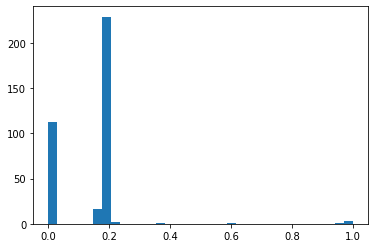

In [71]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

plt.hist(missing_per_column, bins=34)

In [72]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
feat_info.set_index('feat', inplace =True)

eda_mailout_train = eda.EDA(mailout_train, feat_info, label = 'mailout_train')

#  Data Cleaning
eda_mailout_train.data_pipeline()

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_train 
After cleaning, Number of columns is 136 in mailout_train 
Step 2: Convert missing and unknown values ...
Number of missing values in mailout_train:
Before converstion is 691312
Ater converstion IS 957467
Increase in missing values: 38.50 % 
Step 3: Delete the rows with more NaN values ...
Before cleaning, Number of rows is 136 in mailout_train 
After cleaning, Number of columns is 136 in mailout_train 
  7962 lines deleted!
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
   Re-encoding: EINGEFUEGT_AM ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
Step 6: Handling outliers ...
Cleaning outliers for MIN_GEBAEUDEJAHR  ...
Cleaning outliers for EINGEZOGENAM_HH_JAHR  ...


In [73]:
response = response.loc[mailout_train.index]
response.shape

(35000,)

### Preparing and splitting the data

In [74]:
# We split the dataset into 2/3 training and 1/3 testing sets.
train_data, test_data, train_targets, test_targets = train_test_split(
    eda_mailout_train.data_scaled, 
    response, 
    test_size=0.33, 
    shuffle=True,
    random_state=h.RANDOM_STATE)

### Step 4. model evaluation

In [75]:
lrm = LogisticRegression(random_state=h.RANDOM_STATE)
bagm = BaggingClassifier()
lgbm = lgb.LGBMClassifier(random_state=h.RANDOM_STATE,application='binary')

model_dict = {
    'logistic regression': lrm,    
    'bagging': bagm,
    'lgbmclassifier': lgbm,
}

h.build_roc_auc(model_dict, {},eda_mailout_train.data_scaled, response)    

Model: logistic regression,  Best ROC AUC score:  0.7788726497001464
Model: bagging,  Best ROC AUC score:  0.6157437091844391
Model: lgbmclassifier,  Best ROC AUC score:  0.767408164732059


The LGBM classifier got a slightly better score so I'll use it down below to train and tuning for the kaggle competition. 

### Step 5. LGB Train and Hyperparameter Tuning

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:19<00:00,  1.02trial/s, best loss: -0.803676506800905]
Best ROC -0.804 params {'colsample_bytree': 0.6746700257176267, 'feature_fraction': 0.5005231137662433, 'learning_rate': 0.001613169569035531, 'max_bin': 21.0, 'min_data_in_leaf': 1500.0, 'min_sum_hessian_in_leaf': 0.0014444760284803024, 'num_leaves': 6.0, 'reg_alpha': 0.5027768642011887, 'reg_lambda': 0.5414694657746703}


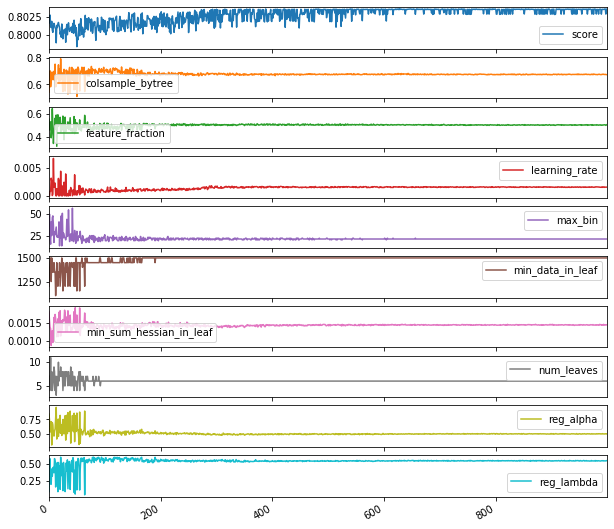

In [76]:
def_params={
        'learning_rate':  {'hpf' :  hp.loguniform('learning_rate', np.log(0.00001), np.log(0.0075)),'dtype' : 'float'},           
        'num_leaves' :    {'hpf' : hp.quniform('num_leaves', 3, 15, 1),'dtype' : 'int'},     
        'min_data_in_leaf' : {'hpf' : hp.quniform('min_data_in_leaf', 1000, 1500, 50),'dtype' : 'int'},     
        'min_sum_hessian_in_leaf':  {'hpf' : hp.uniform('min_sum_hessian_in_leaf', 0.0005, 0.002),'dtype' : 'float'},               
        'colsample_bytree': {'hpf': hp.uniform('colsample_bytree', 0.5, 0.9),'dtype' : 'float'},        
        'reg_alpha': {'hpf': hp.uniform('reg_alpha', 0.3, 1.0),'dtype' : 'float'}, 
        'reg_lambda': {'hpf': hp.uniform('reg_lambda', 0, 0.6),'dtype' : 'float'}, 
        'max_bin' :    {'hpf' : hp.quniform('max_bin', 10, 80, 1),'dtype' : 'int'},    
        'feature_fraction': {'hpf': hp.uniform('feature_fraction', 0.3, 0.7),'dtype' : 'float'},    
}

n_iter = 1000
cv = 10

best, trials, objective = t.search_hyperparameter(def_params, n_iter, cv ,train_data, train_targets)

model = t.build_model(best, def_params)

model.fit(train_data,train_targets)

t.evaluate_model(model, objective, best, test_data, test_targets)

sa_results_df = t.plot_result(trials.trials)

### Step 6. Top 15 most important features of the model

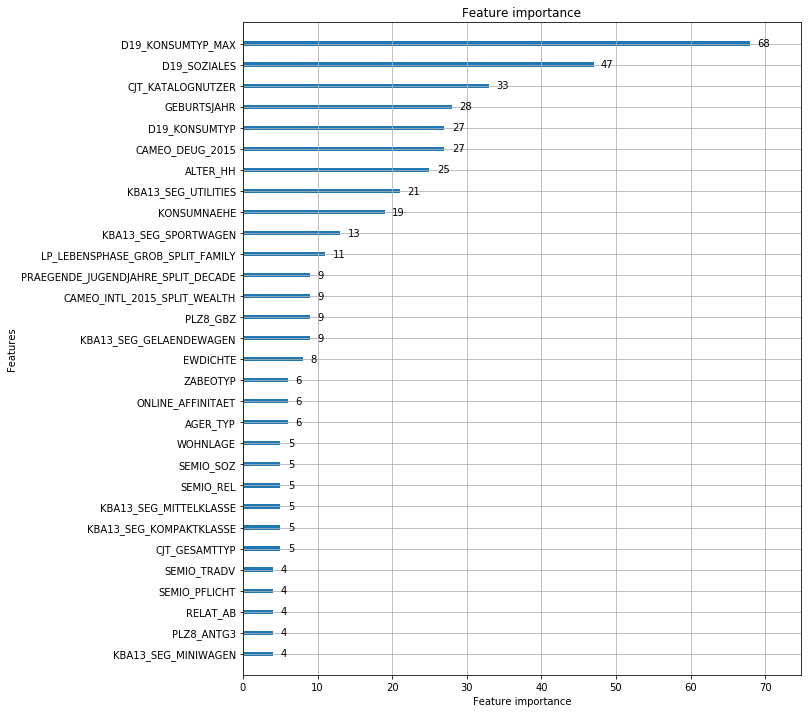

In [77]:
lgb.plot_importance(model, max_num_features = 30, figsize=(10,12))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [78]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_pickle ('..//data//mailout_test.p')    
mailout_test.shape

(42833, 366)

In [79]:
eda_mailout_test = eda.EDA(mailout_test, feat_info, label = 'mailout_test')

In [80]:
LNR = mailout_test.LNR.copy()
LNR.shape

(42833,)

In [81]:
eda_mailout_test.data_pipeline(clean_rows = False)

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_test 
After cleaning, Number of columns is 136 in mailout_test 
Step 2: Convert missing and unknown values ...
Number of missing values in mailout_test:
Before converstion is 680708
Ater converstion IS 945979
Increase in missing values: 38.97 % 
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
   Re-encoding: EINGEFUEGT_AM ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
Step 6: Handling outliers ...
Cleaning outliers for MIN_GEBAEUDEJAHR  ...
Cleaning outliers for EINGEZOGENAM_HH_JAHR  ...
Step 7: Estimating NaN values with median ...
Step 8: Feature scaling ...
Data Cleaning done !


In [82]:
# fit and predict
preds_test = model.predict_proba(eda_mailout_test.data_scaled)[:,1]
preds_test

array([0.51507462, 0.51614416, 0.44550964, ..., 0.49945782, 0.50076699,
       0.50422344])

In [83]:
# create submission file
preds_test = pd.concat([LNR, pd.Series(preds_test)], axis = 1)
preds_test.rename(columns={0:'RESPONSE'}, inplace= True)
preds_test.to_csv('MAILOUT_TEST.csv') 